<a href="https://colab.research.google.com/github/michelleaeh/ADissertation/blob/master/03MScCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project:** MSc in Robotics and Intelligent Systems Dissertation

**Author:** Michelle Alejandra Espinosa Hernandez

**Student registration number:** 1900964

**Student PRID:** ESPIN62803

**Date:** September 2020 

**Purpose:** Obtain classification accuracy among different types of sensors and different data processing steps

# **Data description**

**Myo armband dataset from https://data.mendeley.com/datasets/wgswcr8z24/2**


The dataset consits of .csv files collected from two Myo armbands. The format of the files are [word_name]_[id]. The ‘word_name’ is the English translation of the American Sign Language word used and the ‘id’ is a unique identifier. The .zip for each of the above links has sub-folders for each User.

Each file has 50 columns. They represent a sub-sampled data collection from two Myo devices worn on left and right hands of the signer. The first column is the ‘Counter’ that goes from 1 to 50.

The following columns are of the format: [Sensor][pod/direction][left/right]. For instance the EMG reading for the first EMG pod (out of 8) on the left hand would be called EMG0R and the accelerometer reading for the Z axis on the left hand would be called: AXL

If you use this dataset please cite the following papers:

@inproceedings{paudyal2016sceptre,
title={Sceptre: a pervasive, non-invasive, and programmable gesture recognition technology},
author={Paudyal, Prajwal and Banerjee, Ayan and Gupta, Sandeep KS},
booktitle={Proceedings of the 21st International Conference on Intelligent User Interfaces},
pages={282--293},
year={2016},
organization={ACM}
}

@inproceedings{paudyal2017dyfav,
title={Dyfav: Dynamic feature selection and voting for real-time recognition of fingerspelled alphabet using wearables},
author={Paudyal, Prajwal and Lee, Junghyo and Banerjee, Ayan and Gupta, Sandeep KS},
booktitle={Proceedings of the 22nd International Conference on Intelligent User Interfaces},
pages={457--467},
year={2017},
organization={ACM}
}

**Frequency:**

50Hz sampling rate

**Words:**

*36 total words*

allmorning, bird, blue, cantsleep, cat, colrunnynose, continuouslyforanhour, cost, day, dollar, everymorning, everynight, gold, goodnight, happy, headache, home, horse, hot, hurt, itching, large, mom, monthly, notfeelgood, orange, pizza, please, shirt, soreness, swelling, takeliquidmedicine, thatsterrible, tired, upsetstomach, wash


**Filenames:**

*849 total files*

(word)_(user#)(try#)


**Columns of files:**

Counter  (1 -> 50)

EMG0L -> EMG7L  (EMG sensor readings)

AXL, AYL, AZL  (accelerometer readings)

GXL, GYL, GZL  (gyroscope readings)

ORL, OPL, OYL  (magnetometer readings?)

EMG0R -> EMG7R  (EMG sensor readings)

AXR, AYR, AZR  (accelerometer readings)

GXR, GYR, GZR  (gyroscope readings)

ORR, OPR, OYR  (magnetometer readings?)

features=['EMG0L', 'EMG1L', 'EMG2L', 'EMG3L', 'EMG4L', 'EMG5L', 'EMG6L', 'EMG7L', 'AXL', 'AYL', 'AZL', 'GXL', 'GYL', 'GZL', 'ORL', 'OPL', 'OYL', 'EMG0R', 'EMG1R', 'EMG2R', 'EMG3R', 'EMG4R', 'EMG5R', 'EMG6R', 'EMG7R', 'AXR', 'AYR', 'AZR', 'GXR', 'GYR', 'GZR', 'ORR', 'OPR', 'OYR']


**Size of files:**

All files are 50 rows x 35 columns except continuouslyforanhour_22.csv, headache_52.csv, home_61.csv, and mom_82.csv which are 101 rows x 35 columns

**Steps:**

1. Combine files
2. Normalize or standardize matrix
3. Apply Butterworth
4. Apply PCA
5. Input to SVM


# **Variable definition**

In [1]:
numreps=3      # Number of epochs per word
num_trials=10  # Number of runs of cross validation


# **1. Preparation of data**

**1.1. Start up and initialization of variables**

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os.path
import pandas as pd
import random
import scipy as sp
import time
import warnings

from collections import Counter
from google.colab import files
from mpl_toolkits import mplot3d
from scipy import signal
from scipy.io import loadmat
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from zipfile import ZipFile

# Start timer
starttime = time.time()

# Eliminate warnings
warnings.filterwarnings("ignore")

# Extract all files from zip
with ZipFile("/content/2MyoASL.zip", 'r') as zip:
  zip.extractall()

# Division of sensors
emg=['EMG0L', 'EMG1L', 'EMG2L', 'EMG3L', 'EMG4L', 'EMG5L', 'EMG6L', 'EMG7L', 
     'EMG0R', 'EMG1R', 'EMG2R', 'EMG3R', 'EMG4R', 'EMG5R', 'EMG6R', 'EMG7R']
acc=['AXL', 'AYL', 'AZL', 'AXR', 'AYR', 'AZR']
gyro=['GXL', 'GYL', 'GZL', 'GXR', 'GYR', 'GZR']
ori=['ORL', 'OPL', 'OYL', 'ORR', 'OPR', 'OYR']
colnames=emg[:8]+acc[:3]+gyro[:3]+ori[:3]+emg[8:]+acc[3:]+gyro[3:]+ori[3:]

# Words
words=['allmorning', 'bird', 'blue', 'cantsleep', 'cat', 'coldrunnynose', 'continuouslyforanhour', 'cost', 'day', 
       'dollar', 'everymorning', 'everynight', 'gold', 'goodnight', 'happy', 'headache', 'home', 'horse', 'hot', 
       'hurt', 'itching', 'large', 'mom', 'monthly', 'notfeelgood', 'orange', 'pizza', 'please', 'shirt', 
       'soreness', 'swelling', 'takeliquidmedicine', 'thatsterrible', 'tired', 'upsetstomach', 'wash']

# Generation of matrices
### Combinations of sensors (E=emg=3, A=acc=5, G=gyro=7, O=ori=11)
comb=['E', 'A', 'G', 'O', 'EA', 'EG', 'EO', 'AG', 'AO', 'GO', 'EAG', 'EAO', 'EGO', 'AGO', 'EAGO'] 
products=[3, 5, 7, 11, 15, 21, 33, 35, 55, 77, 105, 165, 231, 385, 1155] 
### Combinations of steps (N=Normalization=3, S=Standardization=5, B=Butterworth=7, P=PCA=11, V=SVM=13)
nsteps=['V', 'NV', 'SV', 'BV', 'PV', 'NBV', 'NPV', 'SBV', 'SPV', 'BPV', 'NBPV', 'SBPV'] 
steps=[13, 39, 65, 91, 143, 273, 429, 455, 715, 1001, 3003, 5005] 
### Placeholders
fresults=np.zeros((len(steps),len(products)))
params=np.zeros((len(steps),len(products)))
headers=np.empty(1701, dtype=object)
lengths=np.zeros(849, dtype=int)
repsum=np.zeros(37,dtype=int)
reps=np.zeros(36,dtype=int)
features=np.zeros(15)
target=np.zeros(15)
fn=np.arange(1701)
matrix=np.zeros(1)
stanproducts=[]
normproducts=[]
regproducts=[]
cmatrix=[]

# Initiation of counters
wordnum=-1
counter=-1
rownum=-1
start=0
num=0
n=0

**1.2. Combine all files**

In [3]:
for w in words:
  repcount=0
  wordnum+=1
  for i in range (10, 120):
    path='/content/2MyoASL/' + w + '_' + str(i) + '.csv'
    if os.path.exists(path)==True:
      counter+=1
      repcount+=1
      trial=pd.read_csv(path)
      trial.reset_index(drop=True)
      
      # Assign word number to each row and make data horizontal
      row=np.zeros(1)
      for t in range(35):
        if t==0:
          row[0]=wordnum
        else:
          sensor=trial.iloc[0:50,t].values
          sensor.reshape([1,50])
          row=np.concatenate((row, sensor))
      prev=row
      
      # Combine all trials
      if counter==0:
        matrix=prev
      else:
        matrix=np.concatenate([matrix,prev])

  reps[wordnum]=repcount
  if wordnum>0:
    repsum[wordnum]=reps[wordnum-1]+repsum[wordnum-1]
    repsum[36]=849

# Create header name array
headers[0]='Word'
for c in colnames:
  for t in range(50):
    num+=1
    headers[num]=c

# Give format to final matrix 
matrix=matrix.reshape([849,1701])
matrix=pd.DataFrame(matrix, columns=headers)
matrix=pd.concat([matrix['Word'],matrix[emg],matrix[acc],matrix[gyro],matrix[ori]],axis=1)
exec("matrix.to_csv(path_or_buf='/content/complete_matrix_'+str(numreps)+'.csv')")
print('Reps of each word:',reps)
print('Cummulative reps:',repsum)

Reps of each word: [19 24 32 20 24 20 19 31 24 29 20 21 23 33 34 18 27 24 35 19 17 34 30 19
 22 21 23 27 27  4 20 19 20 20 21 29]
Cummulative reps: [  0  19  43  75  95 119 139 158 189 213 242 262 283 306 339 373 391 418
 442 477 496 513 547 577 596 618 639 662 689 716 720 740 759 779 799 820
 849]


**1.3. Calculate mean and standard deviation of each sensor and each file**

In [4]:
# Average and standard deviation of each sensor in each file
for s in colnames:
  avg=matrix[s].mean(axis=1)
  sd=matrix[s].std(axis=1)
  sensor=pd.concat([avg.rename(s+': Mean_'),sd.rename('St. dev.')], axis=1)
  if s=='EMG0L':
    asd=sensor
  else:
    asd=pd.concat([asd, sensor], axis=1)
print('Average and standard deviation of each sensor per file')
print(asd)

# Average and standard deviation of each file
avg=matrix.mean(axis=1)
sd=matrix.std(axis=1)
print('Average and standard deviation of each file')
pd.concat([avg.rename('Mean'),sd.rename('St. dev.')], axis=1)

Average and standard deviation of each sensor per file
     EMG0L: Mean_   St. dev.  EMG1L: Mean_  ...   St. dev.  OYR: Mean_   St. dev.
0           -2.32   8.664825         -0.80  ...  28.427609       86.70  10.529356
1           -1.80   9.544739         -4.08  ...  27.821010       85.68   6.579002
2           -3.16  13.085839         -2.32  ...  30.345736       91.88  17.358924
3           -0.82  10.123099         -3.16  ...  29.645002       88.46  12.969682
4           -0.50   6.516071          2.76  ...  13.237239      116.58  18.099600
..            ...        ...           ...  ...        ...         ...        ...
844          0.56   7.754288          0.22  ...  17.236281      104.76   7.528341
845         -1.74   6.520955         -1.20  ...  21.772891       69.66  85.251036
846          1.02   7.731436          0.46  ...  22.707735       56.76  79.408415
847          0.06   5.582078          2.36  ...  23.650422       71.62  84.238701
848         -2.22   7.434860         -1.62 

Mean   St. dev.
0    15.256437  46.545832
1    14.220110  47.316822
2    15.441784  45.614456
3    13.651092  47.038916
4    15.063294  49.105612
..         ...        ...
844  13.167964  41.642351
845  13.815314  42.880121
846  12.970618  42.725653
847  13.852317  43.758631
848  13.144035  44.761750

[849 rows x 2 columns]

# **2. Data adjustement**

**2.1. Establish equal number of epochs per word**

In [5]:
for i in range(len(reps)-1,-1,-1):
  if reps[i]<numreps:
    for r in range(len(matrix)-1,-1,-1):
      if int(matrix.iloc[r]['Word'])==i:
        matrix=matrix.drop(r)
  elif reps[i]>numreps:
    elim=random.sample(range(repsum[i],repsum[i+1]),reps[i]-numreps)
    matrix=matrix.drop(elim)

exec("matrix.to_csv(path_or_buf='/content/equal_matrix_'+str(numreps)+'.csv')")

**2.2. Create sensor combinatory matrices: unaltered, normalized, and standardized**

In [6]:
# Eliminate unnecessary columns to create combinatory matrices
for v in products:
  fnword=[]
  fsword=[]
  m=matrix.copy()
  if v%3!=0:
    m=m.drop(emg,1)
  if v%5!=0:
    m=m.drop(acc,1)
  if v%7!=0:
    m=m.drop(gyro,1)
  if v%11!=0:
    m=m.drop(ori,1)
  
  # Separate features from target values
  x = m.iloc[:, m.columns!='Word']   # Features

  # Create column of words instead of numbers
  wordcol=np.empty(len(m), dtype=object)
  z=0
  wcol=[int(i) for i in m['Word'].values]
  for f in wcol:
    wordcol[z]=words[f]
    z+=1
  wordcol=np.asmatrix(wordcol)
  regular=np.concatenate((np.transpose(wordcol),np.copy(m.iloc[:,1:])),axis=1)
  inputmatrix=pd.DataFrame(regular,columns=m.columns).dropna(axis=1)
  regproducts.append(inputmatrix)

  for pr in range(len(inputmatrix)):
    nemg=[]
    nacc=[]
    ngyro=[]
    nori=[]
    norm=[]
    semg=[]
    sacc=[]
    sgyro=[]
    sori=[]
    stan=[]
    if emg[0] in inputmatrix:
      in_emg=inputmatrix.iloc[pr][emg]
      nemg=(in_emg-in_emg.min())/(in_emg.max()-in_emg.min())
      is_emg=inputmatrix.iloc[pr][emg].values
      is_emg=is_emg[np.newaxis]
      semg=StandardScaler().fit_transform(np.transpose(is_emg))
      semg=semg.reshape(-1)
    if acc[0] in inputmatrix:
      in_acc=inputmatrix.iloc[pr][acc]
      nacc=(in_acc-in_acc.min())/(in_acc.max()-in_acc.min())
      is_acc=inputmatrix.iloc[pr][acc].values
      is_acc=is_acc[np.newaxis]
      sacc=StandardScaler().fit_transform(np.transpose(is_acc))
      sacc=sacc.reshape(-1)
    if gyro[0] in inputmatrix:
      in_gyro=inputmatrix.iloc[pr][gyro]
      ngyro=(in_gyro-in_gyro.min())/(in_gyro.max()-in_gyro.min())
      is_gyro=inputmatrix.iloc[pr][gyro].values
      is_gyro=is_gyro[np.newaxis]
      sgyro=StandardScaler().fit_transform(np.transpose(is_gyro))
      sgyro=sgyro.reshape(-1)
    if ori[0] in inputmatrix:
      in_ori=inputmatrix.iloc[pr][ori]
      nori=(in_ori-in_ori.min())/(in_ori.max()-in_ori.min())
      is_ori=inputmatrix.iloc[pr][ori].values
      is_ori=is_ori[np.newaxis]
      sori=StandardScaler().fit_transform(np.transpose(is_ori))
      sori=sori.reshape(-1)
    
    ## Normalize each type of sensor per sample between 0 and 1
    norm=np.concatenate((np.transpose(nemg),np.transpose(nacc),np.transpose(ngyro),np.transpose(nori)))
    norm=norm[np.newaxis]
    fnword=np.append(fnword,norm)
    fnword=fnword[np.newaxis]
    
    ## Standardize each type of sensor with mean=0 and deviation=1
    stan=np.concatenate((np.transpose(semg),np.transpose(sacc),np.transpose(sgyro),np.transpose(sori)))
    stan=stan[np.newaxis]
    fsword=np.append(fsword,stan)
    fsword=fsword[np.newaxis]

  nmx=np.reshape(fnword,(len(inputmatrix),len(inputmatrix.columns)-1))
  norm_matrix=np.concatenate((np.transpose(wordcol),nmx),axis=1) 
  norm_matrix=pd.DataFrame(norm_matrix,columns=inputmatrix.columns).dropna(axis=1)
  normproducts.append(norm_matrix)
  exec("norm_matrix.to_csv(path_or_buf='/content/norm_matrix_'+str(numreps)+'.'+str(v)+'.csv')")

  smx=np.reshape(fsword,(len(inputmatrix),len(inputmatrix.columns)-1))
  stan_matrix=np.concatenate((np.transpose(wordcol),smx),axis=1) 
  stan_matrix=pd.DataFrame(stan_matrix,columns=inputmatrix.columns).dropna(axis=1)
  stanproducts.append(stan_matrix)
  exec("stan_matrix.to_csv(path_or_buf='/content/stan_matrix_'+str(numreps)+'.'+str(v)+'.csv')")


# **3. Definition of functions for steps**

**3.1. Split data into train and test sets**

In [7]:
def datasplit(inmatrix_p):
    x = inmatrix_p.iloc[:, inmatrix_p.columns!='Word']   # Features
    y = inmatrix_p.loc[:,'Word']                         # Target
    x_train_p, x_test_p, y_train_p, y_test_p = train_test_split(x, y, test_size=0.3)
    return x_train_p, x_test_p, y_train_p, y_test_p

**3.2. Butterworth**

In [8]:
def butterworth(inmatrix_b):
  fs_nyq=50/2
  b, a = sp.signal.butter(8, 20/fs_nyq, btype='highpass', fs=fs_nyq)
  if emg[0] in inmatrix_b:
    for r in range(len(inmatrix_b)):
      in_emg=inmatrix_b.iloc[r][emg].values
      emg_filtered = sp.signal.lfilter(b, a, in_emg)
      emg_filtered=emg_filtered[np.newaxis]
      inmatrix_b.iloc[r,1:len(np.transpose(emg_filtered))+1]=emg_filtered
  return inmatrix_b

**3.3. PCA**

In [9]:
def pca(x_train_c, x_test_c, y_train_c, y_test_c):
  #pca = PCA(n_components=min(len(x_train_c), len(y_train_c)))
  print('PCA inputs')
  print(x_train_c)
  print(type(x_train_c))
  print(x_test_c)
  print(type(x_test_c))
  print(y_train_c)
  print(type(y_train_c))
  print(y_test_c)
  print(type(y_test_c))
  pca = PCA()
  pca.fit(x_train_c)
  x_t_train_pca = pca.transform(x_train_c)
  x_t_test_pca = pca.transform(x_test_c)
  return x_train_c, x_test_c, y_train_c, y_test_c, x_t_train_pca, x_t_test_pca

**3.4. SVM with Grid Search**

In [10]:
def svm(x_train_s, x_test_s, y_train_s, y_test_s, x_t_train_s, x_t_test_s,combo):
    #parameters = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'C':[0.1, 1, 10, 100, 1000]}
    svc = SVC(max_iter=1000)
    nested_scores=np.zeros(num_trials)
    for t in range(num_trials):
      inner_cv=KFold(n_splits=10,shuffle=True,random_state=i)
      outer_cv=KFold(n_splits=10,shuffle=True,random_state=i)
      #clf=GridSearchCV(svc,parameters,scoring='accuracy',n_jobs=1,cv=outer_cv)
      clf=svc
      clf.fit(x_t_train_s, y_train_s)
      nested_scores=cross_val_score(clf,x_t_test_s,y_test_s,cv=outer_cv)
      nested_scores[i]=nested_scores.mean()
    y_pred=clf.predict(x_t_test_s)
    
    # Confusion matrix
    plot_confusion_matrix(clf, x_t_test_s, y_test_s, cmap=plt.cm.Blues)
    plt.title(combo)
    plt.show()

    #bestpar=clf.best_params_
    accuracy=nested_scores.mean()
    svmresult=classification_report(y_test_s, y_pred)
    #return svmresult,accuracy, bestpar
    return svmresult,accuracy

# **4. Main code**

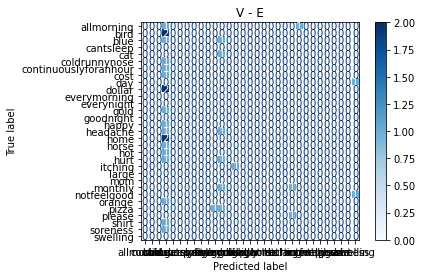

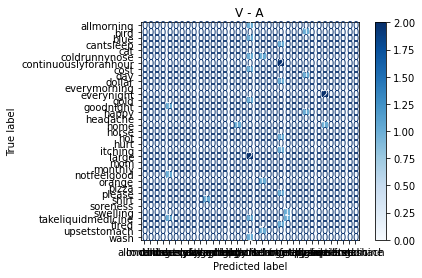

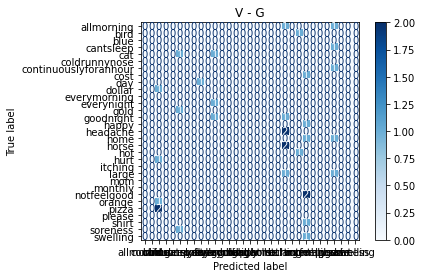

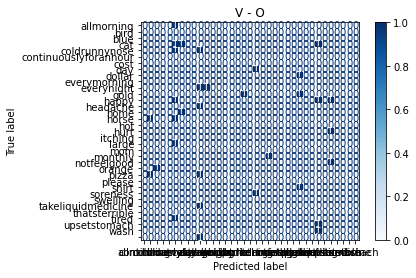

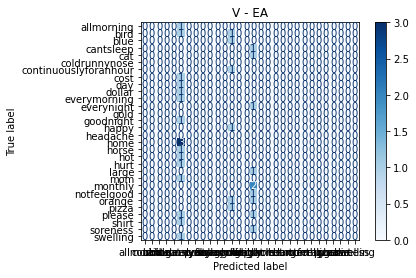

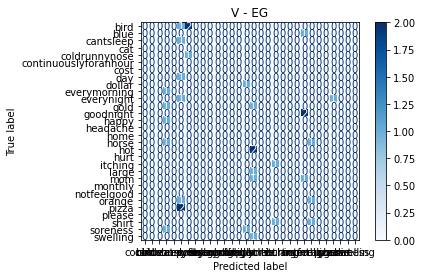

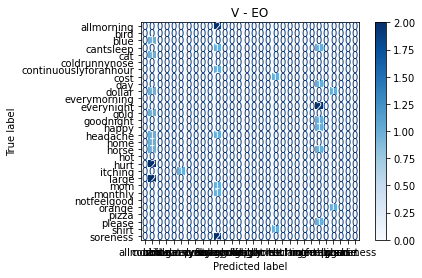

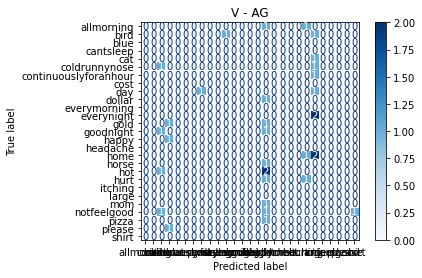

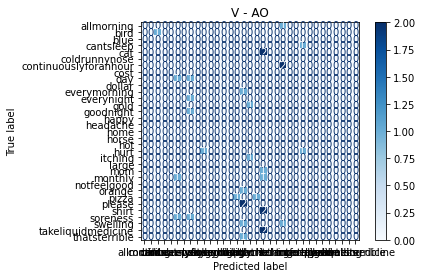

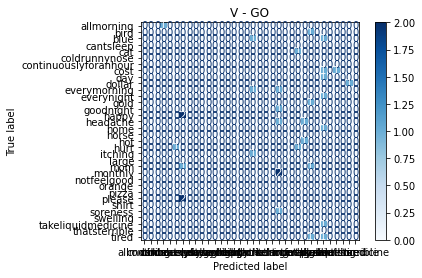

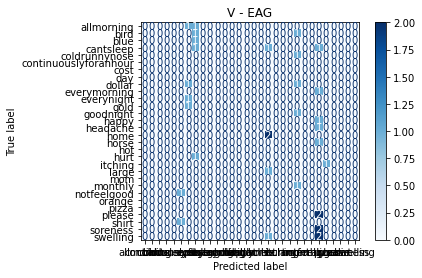

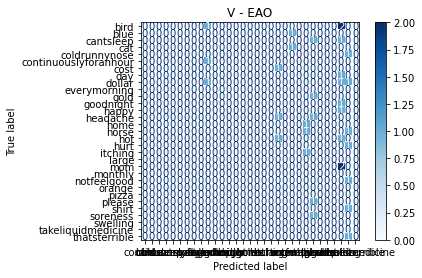

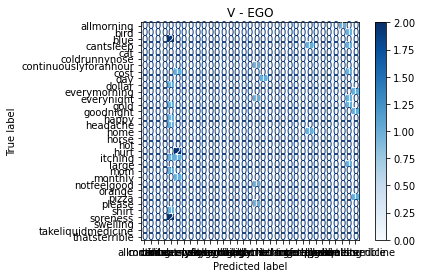

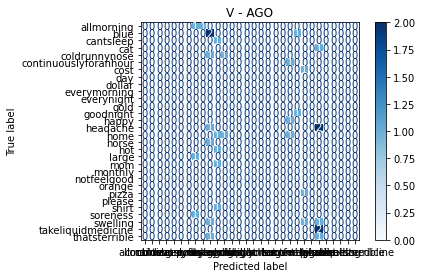

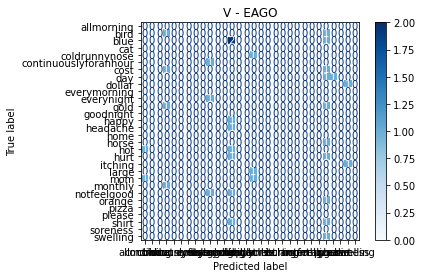

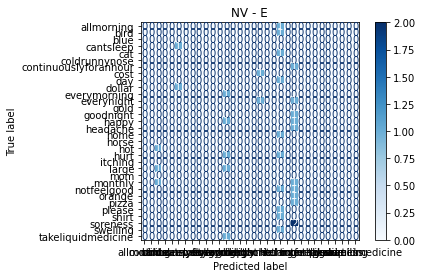

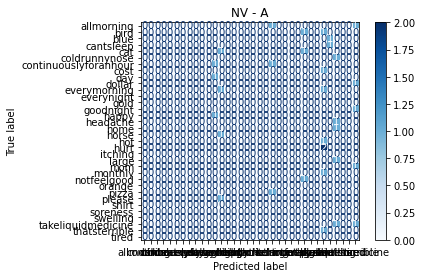

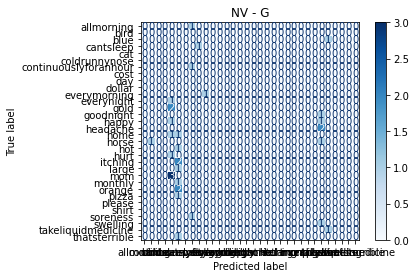

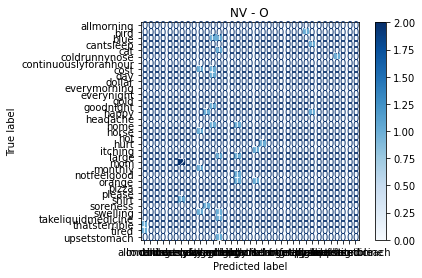

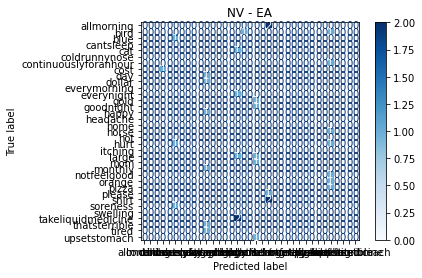

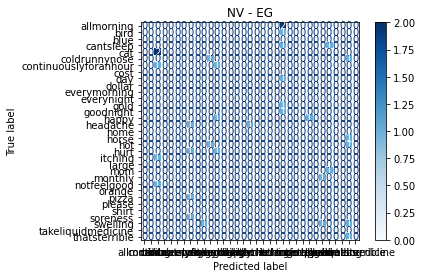

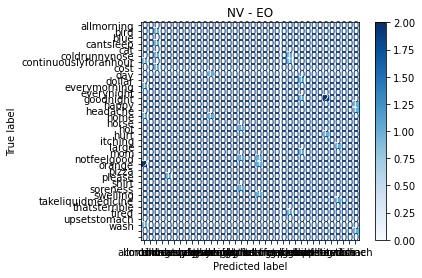

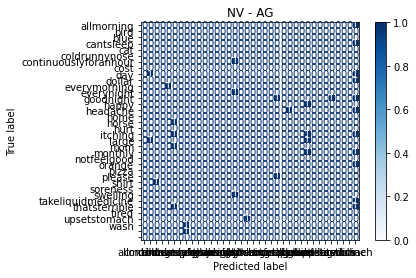

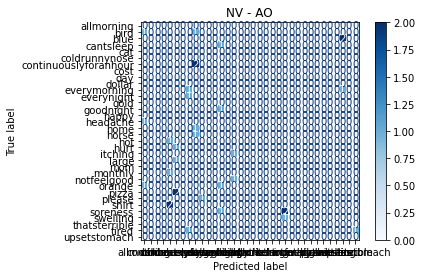

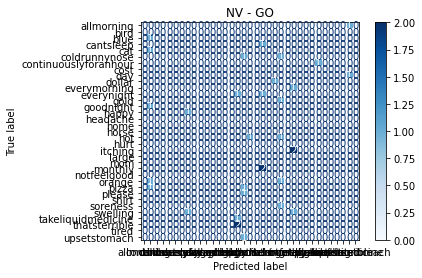

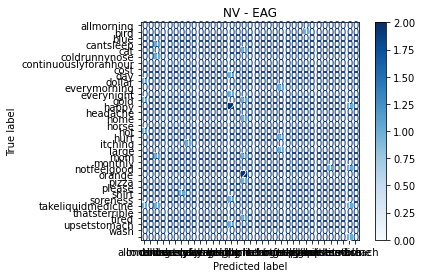

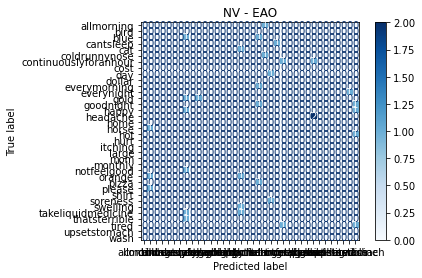

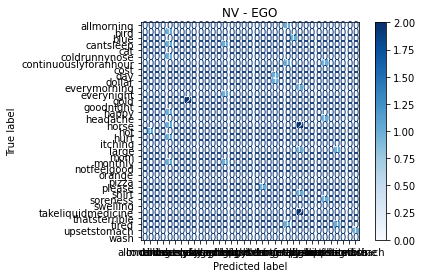

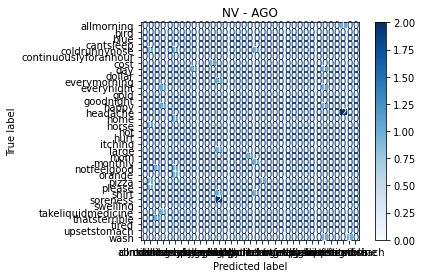

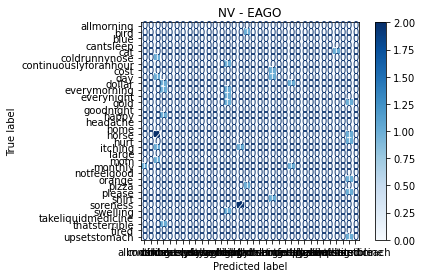

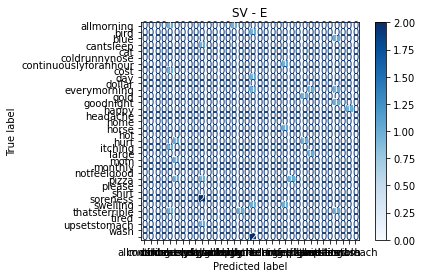

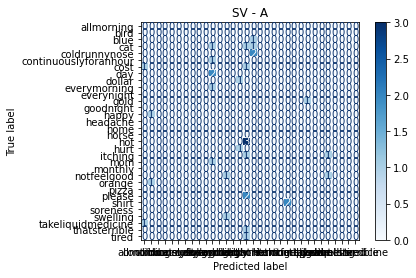

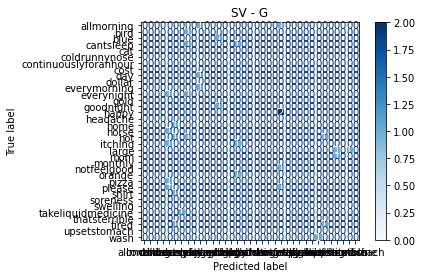

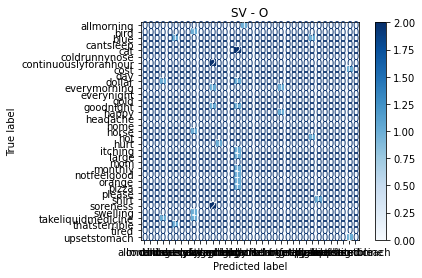

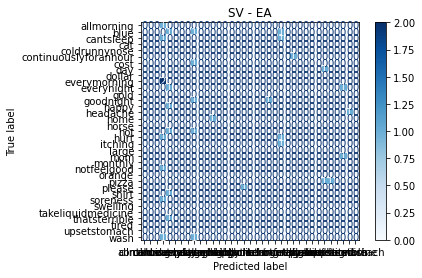

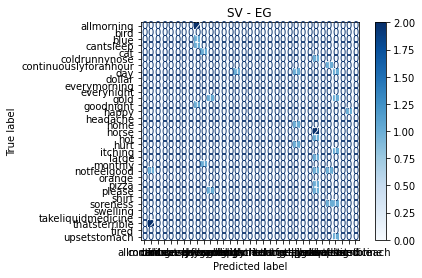

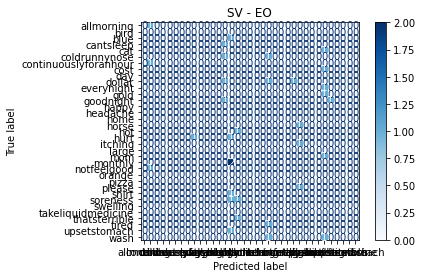

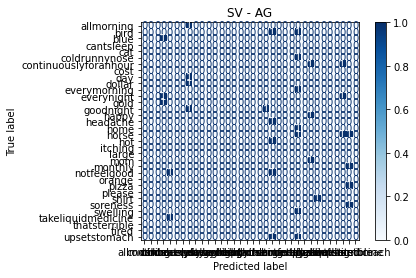

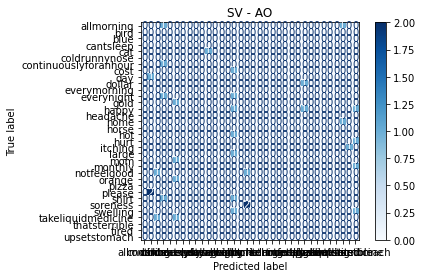

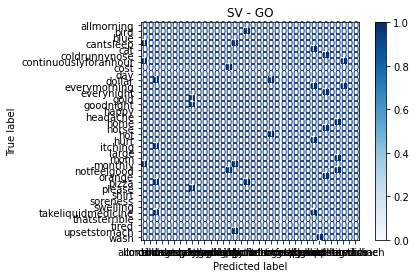

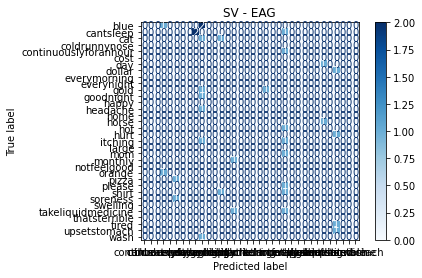

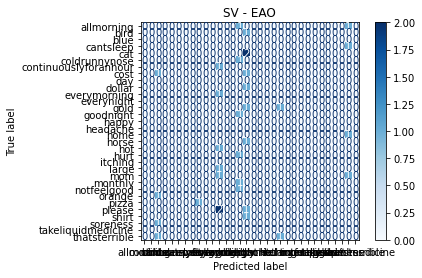

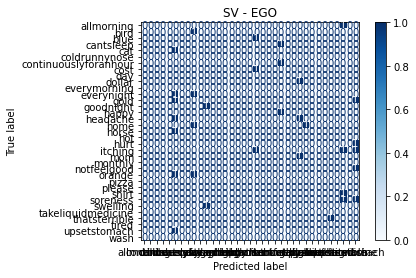

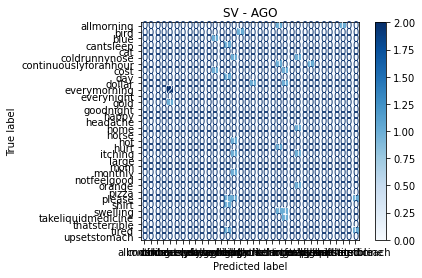

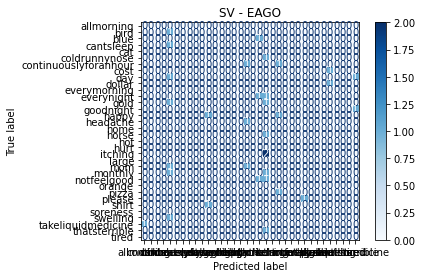

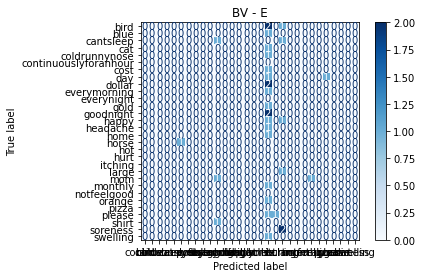

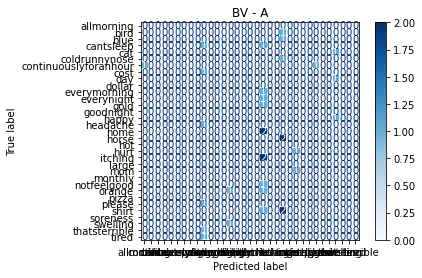

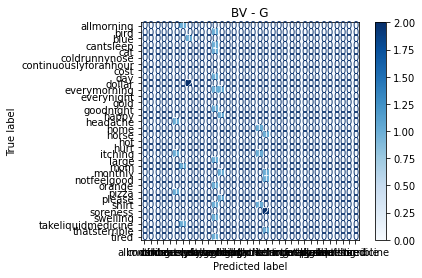

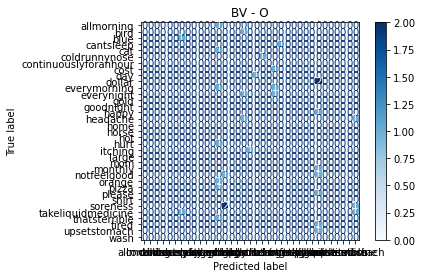

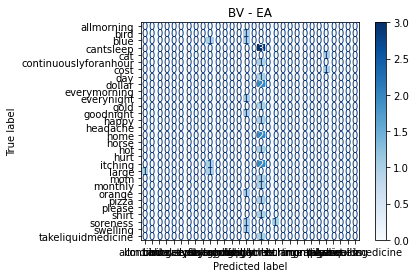

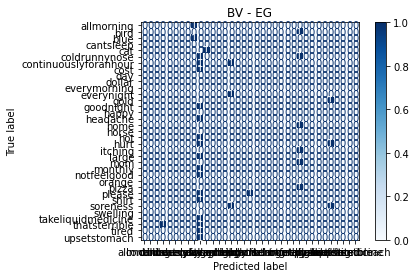

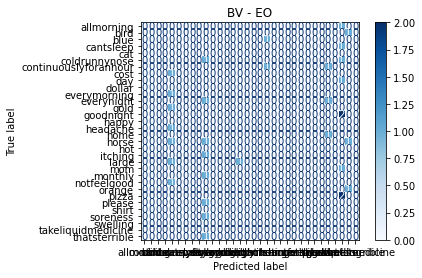

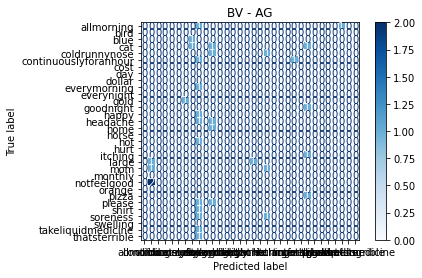

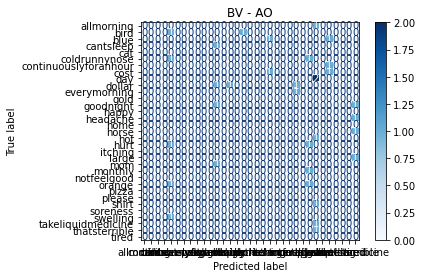

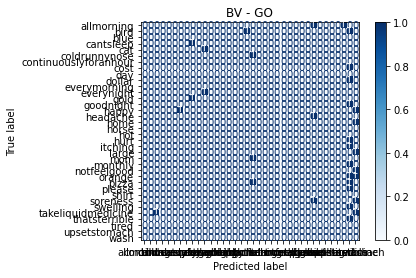

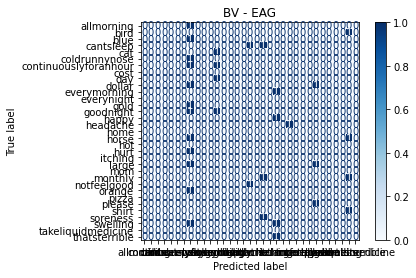

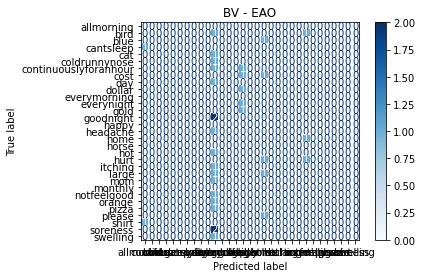

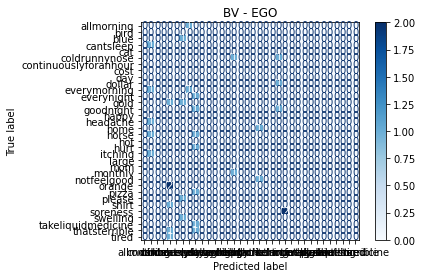

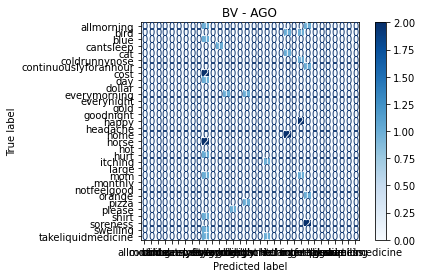

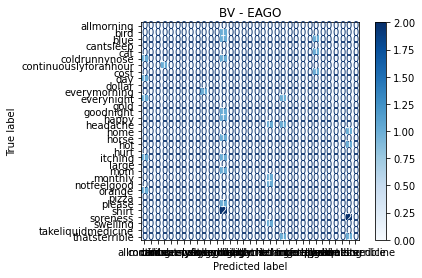

PCA inputs
    EMG0L EMG0L     EMG0L      EMG0L  ...     EMG7R     EMG7R      EMG7R       EMG7R
33      0     0   4.77315   -16.8513  ...  -19.1789   12.0569   -2.06127    -5.35247
38      0     0         0   -1.19329  ...   1.97663    2.1065  -0.373361     -3.7504
45      0     0   3.57986     -6.672  ...  -2.46683  -1.74179   -1.11569 -0.00099151
79      0     0  -1.19329  0.0363065  ... -0.718879   1.56212   0.464524    -3.45067
48      0     0 -0.596644   0.614797  ... -0.801097   1.21533   -1.35947    -1.32165
..    ...   ...       ...        ...  ...       ...       ...        ...         ...
61      0     0         0          0  ...   5.19154 -0.118519    1.01512     0.98303
52      0     0 -0.596644   0.614797  ...   5.53322  -4.25492 -0.0963316   -0.887027
107     0     0 -0.596644   -2.96507  ...  -7.29177  -4.87874   -3.78292    -16.4256
64      0     0  0.596644   -3.00137  ...   1.83428   7.41531    4.13075     4.96161
27      0     0  -4.17651    4.30358  ...     10.91   

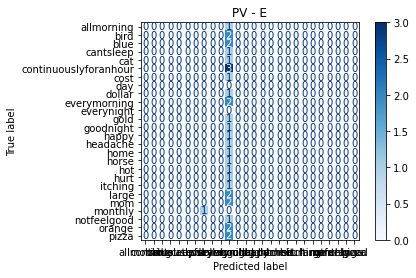

PCA inputs
          AXL        AXL        AXL  ...       AZR       AZR       AZR
66 -0.0878906 -0.0869141 -0.0522461  ...   1.00146  0.997559   1.00781
36   0.522461   0.519531   0.528809  ...  0.875488  0.881836  0.883301
42  -0.446289  -0.457031  -0.560547  ...  0.837891  0.869141  0.879883
41  -0.746094  -0.749023  -0.776367  ...    0.9375  0.936035  0.918945
37  -0.127441     -0.125  -0.125488  ...  0.945312   0.92334  0.840332
..        ...        ...        ...  ...       ...       ...       ...
95  -0.555664  -0.562988  -0.500977  ...  0.433105  0.328125  0.458008
20  -0.703125  -0.730957  -0.668457  ...  0.602051  0.650879  0.672363
46  -0.353027  -0.171387  -0.130859  ...  0.764648  0.895996  0.933594
57   0.175781   0.249512   0.229492  ...  0.798828  0.802734  0.802246
39  -0.730469   -0.73291  -0.625977  ...  0.794922  0.797852  0.795898

[75 rows x 300 columns]
<class 'pandas.core.frame.DataFrame'>
           AXL         AXL        AXL  ...       AZR        AZR        AZR

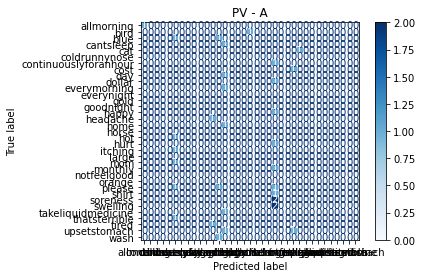

PCA inputs
        GXL      GXL      GXL      GXL  ...      GZR      GZR      GZR      GZR
13   -0.375   2.4375    -0.75    1.875  ...   -2.375   0.3125   0.1875   0.1875
30   200.75    60.75  102.875  86.8125  ...  -8.6875  -5.1875  -1.5625  -0.9375
83   -0.625  -0.6875     2.25      2.5  ...   -146.5 -171.438 -132.875  -115.25
81      -27 -18.1875   -7.875 -10.4375  ... -124.312     -125 -109.062  -78.125
14    2.625   1.0625        4     0.75  ...   1.1875   2.3125  -13.125   -4.125
..      ...      ...      ...      ...  ...      ...      ...      ...      ...
87  32.8125    20.75  107.312   97.625  ...    0.625  12.9375   6.6875   1.4375
72  -9.1875   7.1875       -5    0.125  ...    6.125       24  -4.3125       -5
75     -1.5  -0.8125   1.4375   4.3125  ... -48.6875 -51.0625 -30.3125 -47.3125
52      0.5       -3   2.8125     2.75  ... -107.875    -63.5  -34.125 -30.0625
27       19   3.1875    10.25        4  ...  -0.5625   -0.625  -0.8125  -0.3125

[75 rows x 300 columns]
<cla

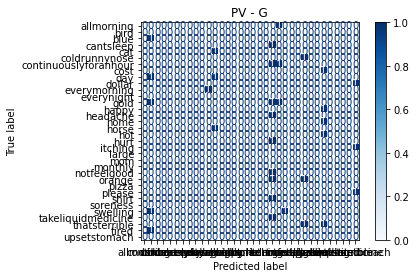

PCA inputs
   ORL ORL ORL ORL ORL ORL ORL ORL  ...  OYR  OYR  OYR  OYR  OYR  OYR  OYR  OYR
6   50  50  50  51  51  51  51  51  ...   68   66   67   69   72   76   79   80
39  87  86  85  83  83  84  86  87  ...  116  116  116  116  116  116  116  115
97  84  84  84  85  85  86  85  84  ...  101  101  101  101  101  101  100  100
48  72  72  72  72  72  72  72  72  ...  101  101  102  103  103  103  104  104
30  76  77  78  80  82  83  85  87  ...   81   81   80   80   80   80   80   80
..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...  ...  ...  ...  ...  ...
12  87  87  87  87  87  87  88  88  ...  111  111  111  111  111  111  111  111
44  77  75  73  72  69  69  70  72  ...   41   41   41   40   40   38   37   36
76  79  79  79  79  79  79  79  79  ...   74   73   72   71   71   71   71   71
71  78  78  80  81  85  87  87  87  ...   65   61   59   58   56   55   54   53
34  87  86  83  82  81  81  82  83  ...   20   20   20   20   20   20   20   20

[75 rows x 300 columns]
<cla

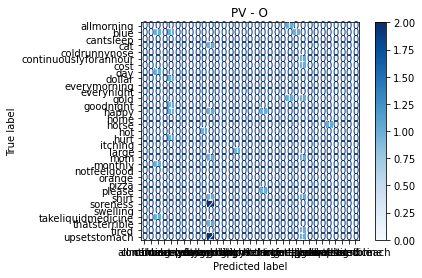

PCA inputs
    EMG0L EMG0L     EMG0L      EMG0L  ...       AZR       AZR       AZR       AZR
39      0     0  -1.19329   0.632951  ...  0.799316  0.794922  0.797852  0.795898
58      0     0   57.2778   -93.0293  ...   1.02197   1.13623  0.934082   1.02588
62      0     0  -1.78993    1.84439  ...  0.781738  0.787598  0.821777  0.836914
41      0     0  0.596644  -0.614797  ...  0.958984    0.9375  0.936035  0.918945
106     0     0  -1.78993    3.03768  ...  0.976074   1.03271    1.0249  0.977051
..    ...   ...       ...        ...  ...       ...       ...       ...       ...
43      0     0         0  -0.596644  ...  0.946289  0.955078  0.964844  0.949707
98      0     0 -0.596644  0.0181533  ...  0.742188   0.75293  0.748535  0.749512
107     0     0 -0.596644   -2.96507  ...  0.878418  0.857422  0.895996  0.894531
91      0     0  -1.19329  -0.560338  ...   0.90625  0.880859  0.916504  0.925781
80      0     0  -1.19329    2.42288  ...  0.808594    0.6875  0.720703  0.763672

[75 

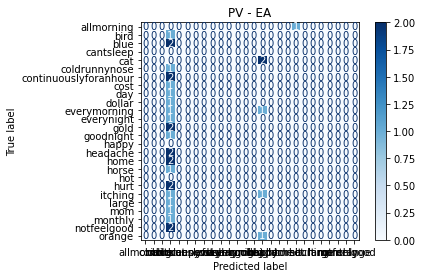

PCA inputs
   EMG0L EMG0L     EMG0L      EMG0L  ...      GZR      GZR      GZR      GZR
0      0     0  -3.57986    18.0082  ... -118.812 -189.188 -241.438  -257.25
65     0     0  0.596644   -3.59802  ...   36.375     6.25     2.75   0.1875
19     0     0  -2.98322    3.67063  ... -15.0625 -21.0625  -0.1875  -1.3125
6      0     0  -1.19329  0.0363065  ...  141.938  168.938    104.5   126.25
37     0     0 -0.596644   0.614797  ...   -5.625   -3.375  -5.1875  -5.1875
..   ...   ...       ...        ...  ...      ...      ...      ...      ...
57     0     0   12.5295   -8.73424  ...       -4  -5.6875   -8.375     -9.5
17     0     0  -2.38658   0.669257  ...     0.75  -0.1875  -0.6875  -1.5625
53     0     0  -1.19329    2.42288  ... -106.625 -100.562 -121.625 -106.375
32     0     0  0.596644   -2.40473  ... -93.9375 -59.3125   -47.75      -36
97     0     0  0.596644   0.578491  ...    -11.5  -9.0625  -8.9375       -8

[75 rows x 1100 columns]
<class 'pandas.core.frame.DataFrame'>
 

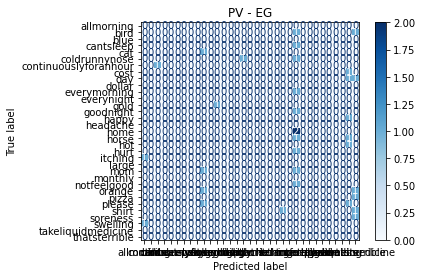

PCA inputs
    EMG0L EMG0L     EMG0L      EMG0L      EMG0L  ...  OYR  OYR  OYR  OYR  OYR
90      0     0 -0.596644   -1.77178    4.54282  ...   78   78   78   78   78
51      0     0 -0.596644  0.0181533   0.311849  ...   14   14   14   14   14
76      0     0  0.596644   -1.80809    1.53254  ...   71   71   71   71   71
42      0     0  -1.78993    1.24775   -2.08398  ...  101  102  102  102  102
63      0     0   4.17651   -1.91701   -3.91842  ...   46   48   48   49   49
..    ...   ...       ...        ...        ...  ...  ...  ...  ...  ...  ...
2       0     0  -1.19329    1.22959   0.587392  ...   23   23   23   23   23
12      0     0 -0.596644  0.0181533  -0.284795  ...  111  111  111  111  111
59      0     0  -5.96644    2.56811    11.9955  ...  165  164  162  160  159
101     0     0         0  -0.596644  0.0181533  ...   72   72   70   70   69
32      0     0  0.596644   -2.40473   0.954052  ...   67   65   64   63   63

[75 rows x 1100 columns]
<class 'pandas.core.frame.D

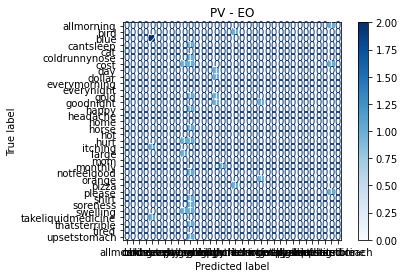

PCA inputs
         AXL        AXL       AXL        AXL  ...      GZR      GZR      GZR     GZR
69 -0.317871  -0.313477 -0.418945  -0.381836  ... -63.5625   -89.25     -115 -144.25
9  -0.289062  0.0913086   0.29834   0.300781  ... -170.188 -138.375 -47.3125  -24.25
19 -0.657715  -0.523438 -0.621582  -0.532227  ... -15.0625 -21.0625  -0.1875 -1.3125
99 -0.517578  -0.442383 -0.291016 -0.0180664  ...  10.8125     6.75   0.8125 -0.9375
57  0.175781   0.249512  0.229492   0.372559  ...       -4  -5.6875   -8.375    -9.5
..       ...        ...       ...        ...  ...      ...      ...      ...     ...
62 -0.523926  -0.526367 -0.527344  -0.529785  ...     -2.5  -3.0625  -0.9375 -0.0625
90 -0.215332  -0.238281 -0.211914  -0.202148  ...   0.8125    -2.25  -2.6875 -2.1875
82 -0.256348  -0.258789 -0.250488  -0.262695  ... -36.8125  -87.375 -105.625 -139.25
16 -0.524414  -0.525879 -0.513672  -0.530273  ...     -5.5     -3.5   -0.875   -0.75
34 -0.769531  -0.808594 -0.798828  -0.524414  ...  -8.

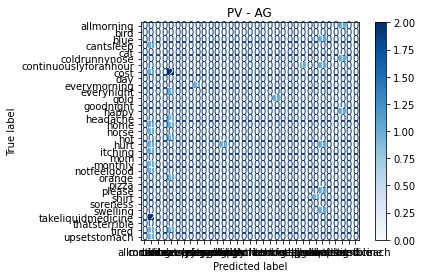

PCA inputs
           AXL        AXL        AXL        AXL  ...  OYR  OYR  OYR  OYR
88   0.0356445    0.14502   0.230469   0.273438  ...   73   73   73   73
7   -0.0493164 -0.0493164 -0.0522461 -0.0810547  ...    8    7    4    0
74   -0.503906  -0.506348  -0.495605  -0.513184  ...   47   47   47   46
39   -0.730469   -0.73291  -0.625977  -0.415039  ...  116  116  116  115
12   -0.630371  -0.622559  -0.608887   -0.60498  ...  111  111  111  111
..         ...        ...        ...        ...  ...  ...  ...  ...  ...
86    0.196289   0.276367   0.400879   0.507324  ...  174  170  165  162
13   -0.434082  -0.438477  -0.449707  -0.452148  ...   89   89   89   89
65    0.668457   0.678711    0.70752   0.750977  ...  171  171  170  169
100   -0.22998  -0.271973  -0.203613  -0.216797  ...  100  100  100  100
8     -0.76416  -0.750488   -0.74707  -0.751465  ...   13    6    3    1

[75 rows x 600 columns]
<class 'pandas.core.frame.DataFrame'>
           AXL         AXL        AXL        AXL  

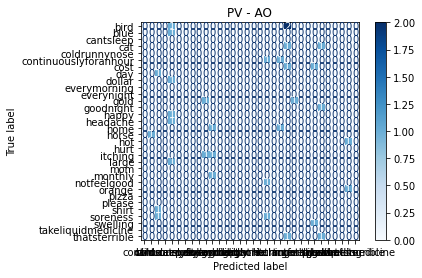

PCA inputs
         GXL      GXL      GXL      GXL      GXL  ...  OYR  OYR  OYR  OYR  OYR
54    -0.125    -2.25  -1.3125  -2.5625  -1.0625  ...   28   28   28   28   28
20   -28.875  -2.6875  87.8125   11.625  15.4375  ...   42   42   41   39   37
107  -84.125   -51.75   -34.25      -26      3.5  ...  102  101   99   97   95
40   15.9375  43.9375  19.5625   -28.25 -42.4375  ...  111  111  111  111  111
10    -9.625  -97.125   -39.75   21.625    10.25  ...   81   80   78   76   73
..       ...      ...      ...      ...      ...  ...  ...  ...  ...  ...  ...
1     9.0625  15.4375 -88.5625 -168.812 -137.375  ...  113  106  102   97   93
16     1.375   0.9375   2.1875   1.0625    1.125  ...   83   83   83   82   82
52       0.5       -3   2.8125     2.75  -3.5625  ...   58   58   58   59   59
41    0.4375       -3  -18.375    -7.75  22.4375  ...   39   38   36   35   33
4      -1.75  -3.6875  -1.4375   0.5625  -1.1875  ...   92   92   92   91   91

[75 rows x 600 columns]
<class 'pandas.c

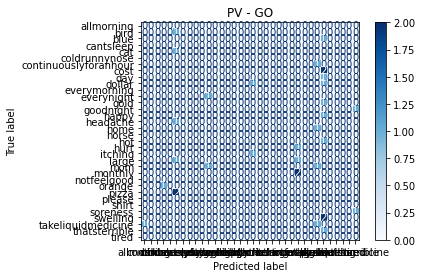

PCA inputs
    EMG0L EMG0L     EMG0L      EMG0L  ...      GZR     GZR     GZR     GZR
56      0     0 -0.596644  -0.578491  ...  18.0625     -10 -9.0625       4
78      0     0         0    1.78993  ... -63.1875 -43.875   -11.5   2.625
60      0     0  -1.78993    2.44104  ...   -6.375  -7.375   -7.25      -1
12      0     0 -0.596644  0.0181533  ...     0.25  2.9375     1.5  -0.375
47      0     0  -1.78993    2.44104  ...    0.375  0.4375    0.25     0.5
..    ...   ...       ...        ...  ...      ...     ...     ...     ...
69      0     0   2.98322    4.68239  ... -63.5625  -89.25    -115 -144.25
18      0     0   1.19329   -8.38932  ...   14.375  0.1875 -5.1875   -1.75
103     0     0  -1.19329   0.632951  ...  -3.6875 -2.4375   -0.25 -0.4375
65      0     0  0.596644   -3.59802  ...   36.375    6.25    2.75  0.1875
16      0     0   1.19329   -2.42288  ...     -5.5    -3.5  -0.875   -0.75

[75 rows x 1400 columns]
<class 'pandas.core.frame.DataFrame'>
    EMG0L EMG0L     EMG0L

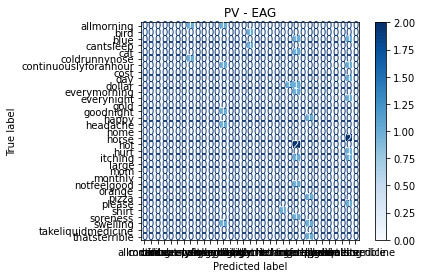

PCA inputs
   EMG0L EMG0L     EMG0L     EMG0L     EMG0L  ...  OYR  OYR  OYR  OYR  OYR
53     0     0  -1.19329   2.42288  -1.23885  ...  129  119  115  112  110
87     0     0  0.596644 -0.614797  -3.27692  ...   72   72   72   73   72
5      0     0  -1.78993  0.651104   1.51404  ...  143  140  137  134  132
27     0     0  -4.17651   4.30358   8.02231  ...   43   43   43   43   43
34     0     0         0  -2.38658  0.669257  ...   20   20   20   20   20
..   ...   ...       ...       ...       ...  ...  ...  ...  ...  ...  ...
22     0     0 -0.596644  -1.17514 -0.248488  ...   41   41   40   40   40
95     0     0  0.596644  -1.21144 -0.872187  ...   48   53   57   57   55
20     0     0   7.75637  -6.79908  -5.64429  ...   42   42   41   39   37
70     0     0   2.98322    -21.57   16.9936  ...   98   99   99   99   99
24     0     0   1.19329  -1.82624  -1.16588  ...    8    8    8    8    8

[75 rows x 1400 columns]
<class 'pandas.core.frame.DataFrame'>
    EMG0L EMG0L     EMG0L

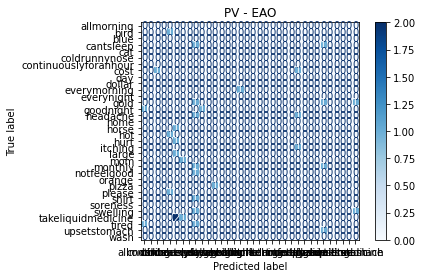

PCA inputs
   EMG0L EMG0L     EMG0L      EMG0L     EMG0L  ...  OYR  OYR  OYR  OYR  OYR
97     0     0  0.596644   0.578491   5.63644  ...  101  101  101  100  100
18     0     0   1.19329   -8.38932  -5.73935  ...   86   87   87   87   87
41     0     0  0.596644  -0.614797  0.302948  ...   39   38   36   35   33
16     0     0   1.19329   -2.42288  -1.14773  ...   83   83   83   82   82
36     0     0  0.596644   -1.21144  -1.46883  ...    6    6    6    6    6
..   ...   ...       ...        ...       ...  ...  ...  ...  ...  ...  ...
3      0     0 -0.596644  -0.578491  0.926647  ...  125  125  125  124  124
11     0     0 -0.596644  0.0181533 -0.881439  ...   97   97   97   95   94
86     0     0  0.596644   -3.59802   2.18365  ...  177  174  170  165  162
83     0     0   1.19329   -4.80946   2.50475  ...   92   90   81   75   73
79     0     0  -1.19329  0.0363065  0.623699  ...  172  170  170  171  172

[75 rows x 1400 columns]
<class 'pandas.core.frame.DataFrame'>
    EMG0L EMG

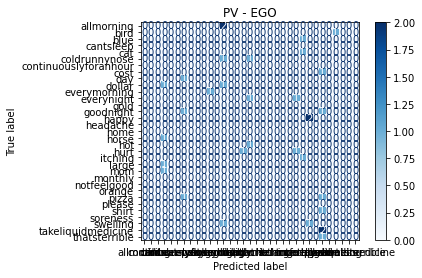

PCA inputs
           AXL        AXL        AXL        AXL  ...  OYR  OYR  OYR  OYR
92   0.0952148  0.0415039 -0.0859375  -0.153809  ...   62   62   62   62
49    -0.12793  -0.134766 -0.0957031 -0.0966797  ...   14   14   14   14
80   -0.609863  -0.612793  -0.610352  -0.611328  ...   84   84   84   84
43   -0.297852  -0.295898  -0.294434  -0.296387  ...   65   65   65   65
62   -0.523926  -0.526367  -0.527344  -0.529785  ...   68   68   68   68
..         ...        ...        ...        ...  ...  ...  ...  ...  ...
6     -0.39502  -0.407227  -0.392578  -0.404297  ...   72   76   79   80
90   -0.215332  -0.238281  -0.211914  -0.202148  ...   78   78   78   78
107  -0.409668  -0.407227  -0.226562 -0.0996094  ...  101   99   97   95
5    -0.591797  -0.600098   -0.59082   -0.59082  ...  140  137  134  132
89    0.411133   0.237305  0.0175781  0.0922852  ...   73   73   73   74

[75 rows x 900 columns]
<class 'pandas.core.frame.DataFrame'>
           AXL        AXL        AXL        AXL  .

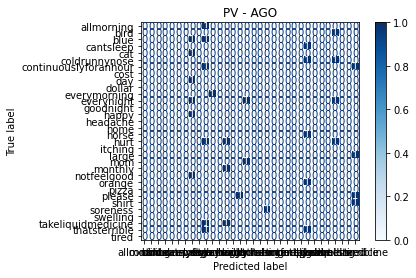

PCA inputs
    EMG0L EMG0L     EMG0L      EMG0L     EMG0L  ...  OYR  OYR  OYR  OYR  OYR
96      0     0  -2.98322    0.68741   12.8773  ...   81   81   81   81   81
32      0     0  0.596644   -2.40473  0.954052  ...   67   65   64   63   63
10      0     0  -2.98322   -2.29581   8.19495  ...   81   80   78   76   73
20      0     0   7.75637   -6.79908  -5.64429  ...   42   42   41   39   37
71      0     0  -7.75637    10.3789  -4.01094  ...   58   56   55   54   53
..    ...   ...       ...        ...       ...  ...  ...  ...  ...  ...  ...
103     0     0  -1.19329   0.632951   1.20219  ...   84   84   84   84   84
97      0     0  0.596644   0.578491   5.63644  ...  101  101  101  100  100
0       0     0  -3.57986    18.0082  -13.5896  ...  131  128  123  116  111
6       0     0  -1.19329  0.0363065   3.01028  ...   69   72   76   79   80
27      0     0  -4.17651    4.30358   8.02231  ...   43   43   43   43   43

[75 rows x 1700 columns]
<class 'pandas.core.frame.DataFrame'>
 

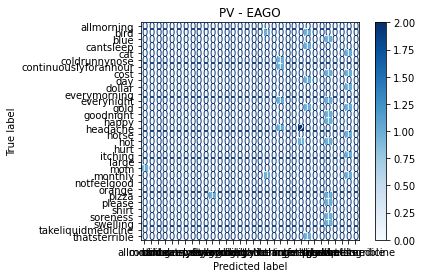

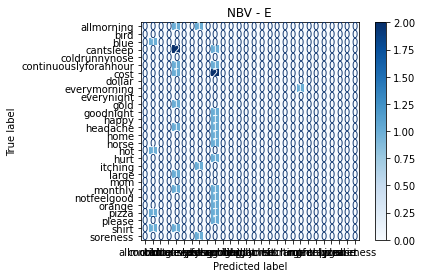

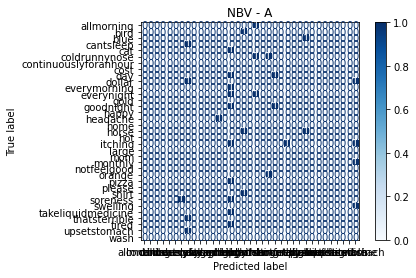

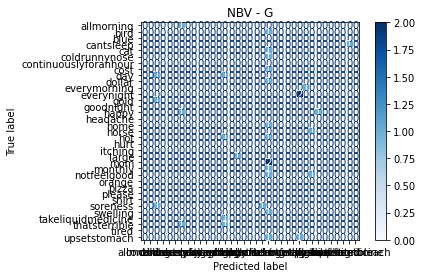

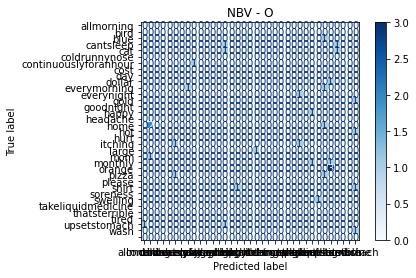

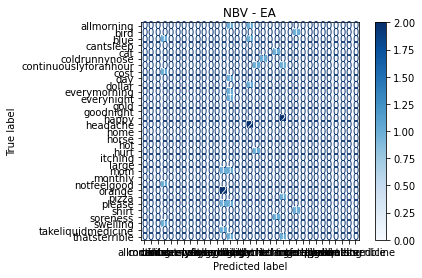

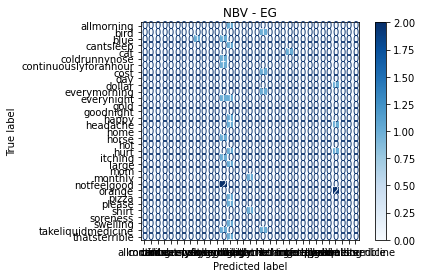

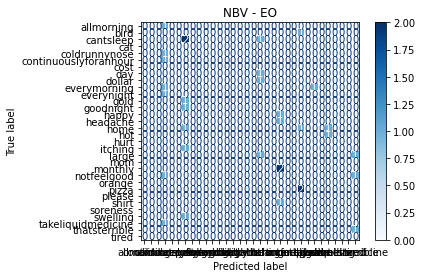

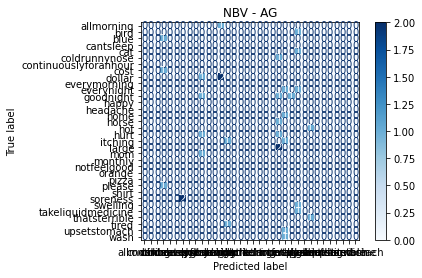

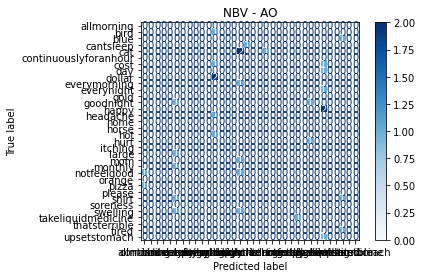

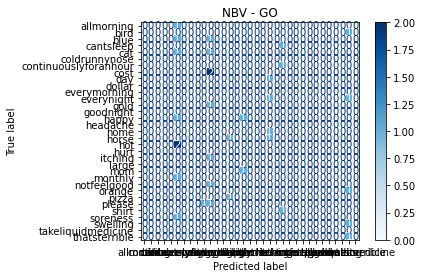

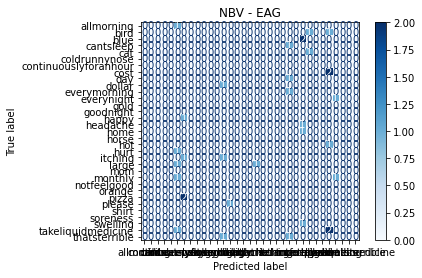

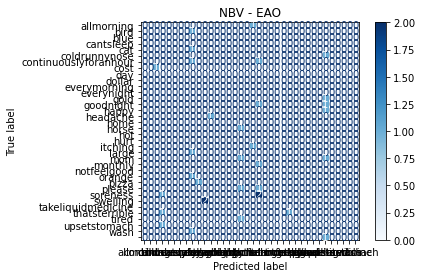

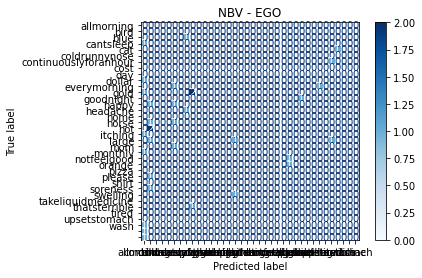

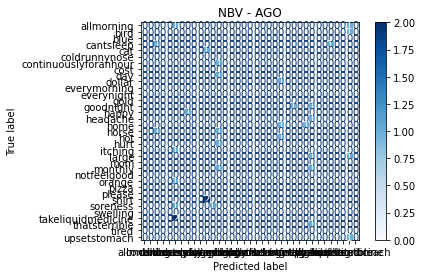

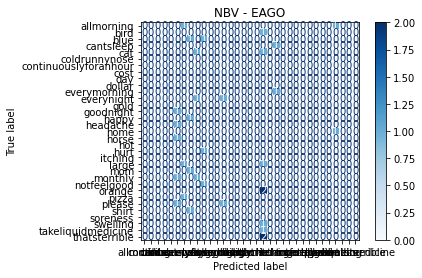

PCA inputs
       EMG0L       EMG0L       EMG0L  ...       EMG7R       EMG7R       EMG7R
19  0.300788 -0.00915164   -0.169541  ...  -0.0631925  -0.0852839  -0.0960479
59  0.270178 -0.00822034    -0.17874  ...   -0.011748  -0.0118273  -0.0213938
28  0.369351  -0.0112377    -0.19305  ...   0.0112899   0.0169454   0.0174137
82  0.352562  -0.0107269   -0.174105  ...  -0.0158249   -0.010555  -0.0237171
54  0.178004 -0.00541589  -0.0172213  ...  0.00718662   0.0353665  -0.0143302
..       ...         ...         ...  ...         ...         ...         ...
99  0.294481 -0.00895976   -0.176963  ...  0.00415056   0.0170716    0.021209
94  0.305818 -0.00930468   -0.144851  ...   0.0363481  0.00946431  0.00120995
57  0.235373 -0.00716138 -0.00807337  ... -0.00392658  0.00304798 -0.00263645
83  0.259256 -0.00788802   -0.128403  ...  -0.0180483  -0.0182066  -0.0505614
24  0.230227 -0.00700479   -0.113848  ...  0.00506311 -0.00585308  -0.0034677

[75 rows x 800 columns]
<class 'pandas.core.frame.Da

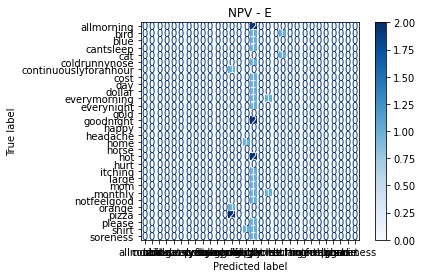

PCA inputs
           AXL       AXL        AXL  ...       AZR       AZR       AZR
47    0.200162  0.398509   0.618626  ...  0.751261  0.751866  0.753277
102   0.350965  0.353008   0.345971  ...   0.89058  0.890126   0.89285
9     0.249737   0.38626   0.460568  ...  0.584823  0.731334  0.688223
87    0.202132   0.30483   0.409704  ...   0.76436   0.74456  0.834204
16   0.0220127  0.021155  0.0283019  ...  0.773583  0.757002  0.757574
..         ...       ...        ...  ...       ...       ...       ...
96    0.112934   0.12078   0.125535  ...  0.734665  0.738945  0.736331
3      0.12419  0.123497   0.108464  ...  0.800878   0.80666  0.831406
69    0.241557  0.243493   0.197032  ...  0.763605  0.777801  0.787911
28    0.577819  0.567543   0.562405  ...  0.935987  0.920573  0.959965
6     0.193668   0.18963   0.194476  ...  0.554676         1  0.711355

[75 rows x 300 columns]
<class 'pandas.core.frame.DataFrame'>
           AXL        AXL        AXL  ...       AZR       AZR       AZR
68

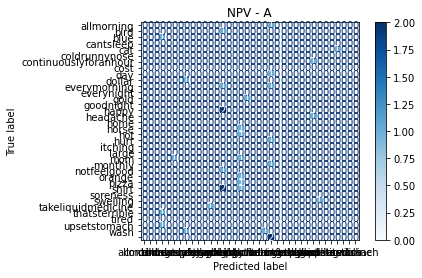

PCA inputs
          GXL       GXL       GXL  ...       GZR       GZR       GZR
75   0.451696  0.453201  0.458127  ...  0.343184  0.388614  0.351395
99     0.7186  0.630223  0.657528  ...  0.427727   0.41714  0.414019
44   0.379708  0.295347  0.236803  ...  0.421149  0.404046  0.415229
30   0.853632   0.55284  0.643346  ...  0.411172   0.41896  0.420303
4    0.404153  0.398557  0.405056  ...  0.401084  0.389713  0.365344
..        ...       ...       ...  ...       ...       ...       ...
70   0.258208  0.314435  0.288877  ...  0.490705  0.447335  0.425804
91   0.529281  0.525242  0.521877  ...  0.524569  0.517389  0.505947
106  0.526874  0.501893  0.517033  ...  0.538835  0.551401  0.555035
93   0.440179  0.431818  0.468559  ...   0.45113  0.468088  0.408973
32    0.43317  0.504361  0.584748  ...  0.352942  0.382274  0.412083

[75 rows x 300 columns]
<class 'pandas.core.frame.DataFrame'>
          GXL       GXL       GXL  ...        GZR        GZR        GZR
63   0.560792  0.506972  0

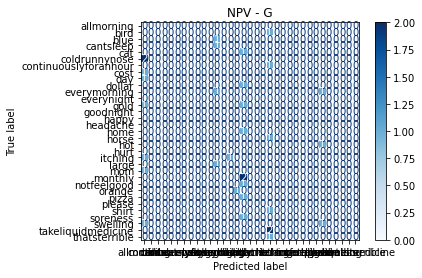

PCA inputs
         ORL       ORL       ORL  ...       OYR       OYR       OYR
26  0.357542  0.357542  0.357542  ...   0.96648  0.944134  0.927374
14  0.607692  0.607692  0.607692  ...  0.515385  0.507692  0.507692
85  0.702381  0.702381  0.702381  ...  0.654762  0.654762  0.642857
67  0.351955  0.351955  0.346369  ...  0.821229  0.815642  0.815642
86  0.351955  0.351955  0.368715  ...  0.949721  0.921788  0.905028
..       ...       ...       ...  ...       ...       ...       ...
81  0.416667  0.416667  0.383333  ...  0.566667       0.5  0.433333
66  0.868687  0.868687  0.868687  ...   0.20202   0.20202   0.20202
28  0.335196  0.329609  0.324022  ...  0.905028  0.899441  0.893855
76  0.530612  0.530612  0.530612  ...  0.367347  0.367347  0.367347
11  0.582418  0.582418  0.582418  ...  0.747253  0.725275  0.714286

[75 rows x 300 columns]
<class 'pandas.core.frame.DataFrame'>
           ORL        ORL        ORL  ...        OYR        OYR        OYR
58    0.586957   0.565217   0.52173

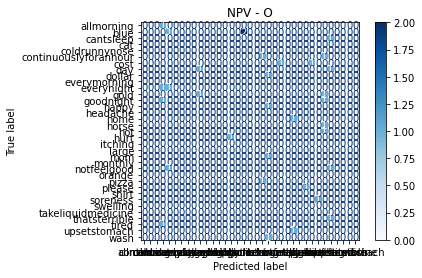

PCA inputs
       EMG0L       EMG0L     EMG0L  ...       AZR       AZR       AZR
84  0.299492 -0.00911222 -0.142497  ...  0.896201  0.901135  0.896449
31  0.227293 -0.00691553 -0.125903  ...  0.869228  0.809905   0.79804
39  0.265175 -0.00806811 -0.146399  ...  0.778766  0.780251   0.77926
38  0.439862  -0.0133831 -0.229904  ...  0.588107  0.593926  0.591926
32  0.289282 -0.00880158  -0.14216  ...  0.968774  0.947672  0.932639
..       ...         ...       ...  ...       ...       ...       ...
81  0.312233 -0.00949989 -0.178653  ...  0.893565   0.82138  0.813564
77  0.310449  -0.0094456 -0.164688  ...  0.679834  0.718371   0.72855
49  0.238658  -0.0072613 -0.159544  ...  0.905594  0.906188  0.896124
17  0.247181 -0.00752063 -0.146242  ...  0.816408  0.812502  0.806154
48  0.332556  -0.0101182 -0.178708  ...  0.667927  0.679492  0.683976

[75 rows x 1100 columns]
<class 'pandas.core.frame.DataFrame'>
        EMG0L       EMG0L       EMG0L  ...       AZR       AZR       AZR
4    0.28638

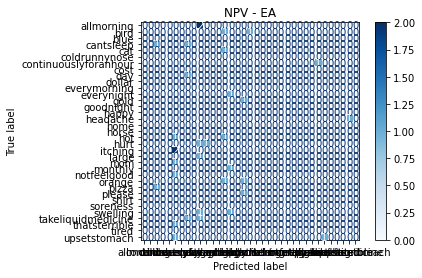

PCA inputs
        EMG0L       EMG0L     EMG0L  ...        GZR       GZR       GZR
1    0.340417  -0.0103574 -0.185247  ...  0.0351987  0.107871  0.208028
95   0.339424  -0.0103272 -0.174756  ...   0.607416  0.456935  0.377183
82   0.352562  -0.0107269 -0.174105  ...   0.319267  0.277064  0.199307
85   0.308266 -0.00937918 -0.161122  ...   0.816002  0.806524  0.783663
31   0.227293 -0.00691553 -0.125903  ...     0.5103  0.525548  0.529963
..        ...         ...       ...  ...        ...       ...       ...
106  0.351706  -0.0107009 -0.202668  ...   0.538835  0.551401  0.555035
97   0.357986   -0.010892 -0.183795  ...   0.539072  0.539468  0.542443
71   0.287107  -0.0087354 -0.208381  ...   0.240089  0.267158  0.276279
12   0.368142  -0.0112009 -0.196649  ...   0.436077    0.4332  0.429447
6    0.268096 -0.00815697 -0.145383  ...   0.946439  0.805205  0.852877

[75 rows x 1100 columns]
<class 'pandas.core.frame.DataFrame'>
        EMG0L       EMG0L     EMG0L  ...       GZR        GZR

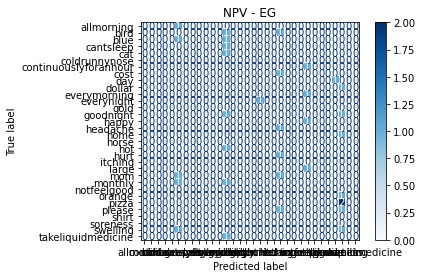

PCA inputs
        EMG0L       EMG0L      EMG0L  ...        OYR        OYR        OYR
59   0.270178 -0.00822034   -0.17874  ...   0.904494   0.893258    0.88764
10   0.207693 -0.00631917  -0.127436  ...   0.588235   0.564706   0.529412
41   0.267653 -0.00814352  -0.134319  ...  0.0733945  0.0642202  0.0458716
54   0.178004 -0.00541589 -0.0172213  ...          0          0          0
86   0.299492 -0.00911222  -0.154196  ...   0.949721   0.921788   0.905028
..        ...         ...        ...  ...        ...        ...        ...
97   0.357986   -0.010892  -0.183795  ...    0.82243   0.813084   0.813084
29   0.302524 -0.00920447  -0.212743  ...   0.954128   0.954128   0.954128
11   0.278652 -0.00847817  -0.148922  ...   0.747253   0.725275   0.714286
48   0.332556  -0.0101182  -0.178708  ...   0.577778   0.585185   0.585185
104  0.292693 -0.00890537  -0.152983  ...          1   0.980392   0.941176

[75 rows x 1100 columns]
<class 'pandas.core.frame.DataFrame'>
        EMG0L       EMG0L

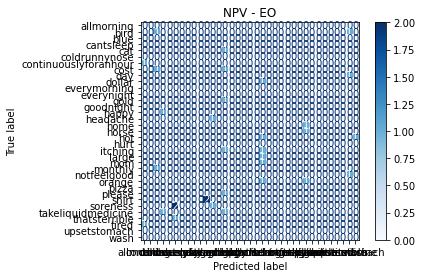

PCA inputs
         AXL        AXL        AXL  ...       GZR       GZR       GZR
80  0.069544  0.0683166  0.0693391  ...  0.402821   0.39455  0.392112
93  0.340054   0.342114    0.34374  ...   0.45113  0.468088  0.408973
55  0.398042   0.397784   0.392886  ...  0.305854  0.296748  0.282764
99  0.125962   0.149193   0.195957  ...  0.427727   0.41714  0.414019
85  0.308031    0.30886   0.306927  ...  0.816002  0.806524  0.783663
..       ...        ...        ...  ...       ...       ...       ...
72  0.379628   0.386852   0.461803  ...  0.474248  0.403971  0.402265
31  0.349497   0.378385   0.379417  ...    0.5103  0.525548  0.529963
58  0.253932    0.21552   0.133798  ...  0.565231  0.544632  0.566792
40  0.366549    0.35749   0.339373  ...   0.63446   0.61476  0.632584
49  0.220184    0.21604   0.239716  ...  0.440463  0.439016  0.440282

[75 rows x 600 columns]
<class 'pandas.core.frame.DataFrame'>
            AXL        AXL        AXL  ...       GZR        GZR       GZR
29     0.230

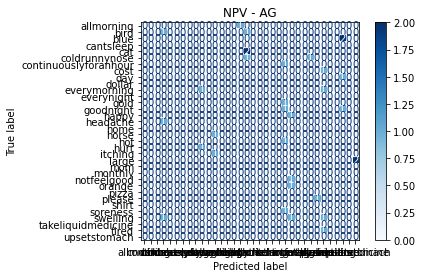

PCA inputs
         AXL       AXL       AXL  ...        OYR        OYR        OYR
91  0.235211  0.233803   0.24507  ...          0          0          0
34  0.123167   0.10641  0.110599  ...   0.101695   0.101695   0.101695
90  0.294488  0.282658   0.29625  ...   0.326087   0.326087   0.326087
54  0.242761  0.238374  0.238959  ...          0          0          0
83  0.198909  0.192633  0.202183  ...   0.508197   0.409836   0.377049
..       ...       ...       ...  ...        ...        ...        ...
67  0.410115  0.409356  0.411379  ...   0.821229   0.815642   0.815642
17  0.125733  0.125245  0.131836  ...          0          0          0
93  0.340054  0.342114   0.34374  ...    0.62766    0.62766    0.62766
52  0.118854  0.114385  0.106664  ...   0.308943   0.317073   0.317073
51  0.531374  0.532246  0.532681  ...  0.0797546  0.0797546  0.0797546

[75 rows x 600 columns]
<class 'pandas.core.frame.DataFrame'>
           AXL        AXL        AXL  ...       OYR       OYR       OYR
10

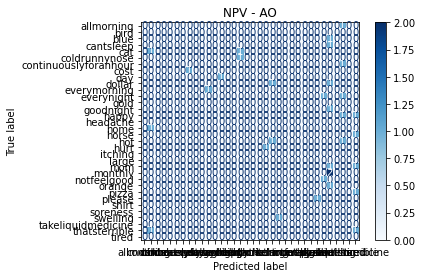

PCA inputs
          GXL       GXL       GXL  ...       OYR       OYR       OYR
50   0.605196  0.602768  0.604711  ...  0.563218  0.563218  0.563218
2    0.275358  0.251881  0.581842  ...  0.135135  0.135135  0.135135
64   0.695007  0.696716  0.811918  ...  0.647541  0.680328  0.704918
60   0.381455  0.390995  0.444925  ...         0         0         0
43   0.650281  0.653778  0.653389  ...  0.424658  0.424658  0.424658
..        ...       ...       ...  ...       ...       ...       ...
10    0.48295  0.313664  0.424667  ...  0.588235  0.564706  0.529412
100  0.505068  0.614589  0.800635  ...      0.79      0.79      0.79
24   0.584491  0.588547  0.570358  ...         0         0         0
101  0.481157  0.372085  0.333401  ...  0.438202  0.438202  0.426966
11   0.380452  0.381043  0.352062  ...  0.747253  0.725275  0.714286

[75 rows x 600 columns]
<class 'pandas.core.frame.DataFrame'>
          GXL       GXL       GXL  ...        OYR        OYR        OYR
12   0.428446  0.434326   

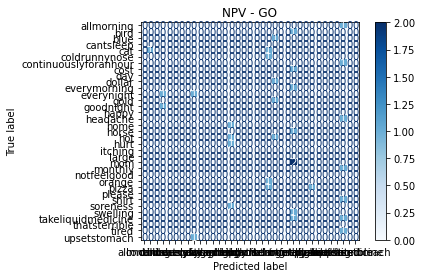

PCA inputs
        EMG0L       EMG0L      EMG0L  ...        GZR       GZR        GZR
74   0.317992 -0.00967509  -0.159649  ...   0.449948  0.447225   0.446806
99   0.294481 -0.00895976  -0.176963  ...   0.427727   0.41714   0.414019
97   0.357986   -0.010892  -0.183795  ...   0.539072  0.539468   0.542443
69   0.331469  -0.0100851  -0.147752  ...    0.30216  0.252701   0.196518
35   0.275374 -0.00837843   -0.15158  ...   0.519608   0.52077   0.520577
..        ...         ...        ...  ...        ...       ...        ...
96   0.291105 -0.00885703  -0.164181  ...   0.612453  0.612029   0.616406
77   0.310449  -0.0094456  -0.164688  ...   0.528027  0.523243   0.527904
107  0.235771 -0.00717346  -0.128042  ...  0.0589729         0  0.0394455
103     0.272 -0.00827575  -0.150941  ...   0.372974  0.379981    0.37938
54   0.178004 -0.00541589 -0.0172213  ...   0.605976  0.599358   0.600303

[75 rows x 1400 columns]
<class 'pandas.core.frame.DataFrame'>
        EMG0L       EMG0L     EMG0L  

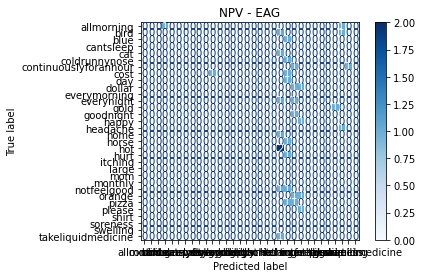

PCA inputs
        EMG0L       EMG0L      EMG0L  ...        OYR        OYR        OYR
101  0.262354 -0.00798228  -0.137125  ...   0.438202   0.438202   0.426966
100  0.331469  -0.0100851  -0.165884  ...       0.79       0.79       0.79
80   0.309053 -0.00940313  -0.170118  ...   0.448718   0.448718   0.448718
16   0.179871 -0.00547267 -0.0852392  ...   0.569767    0.55814    0.55814
73   0.255308  -0.0077679  -0.133443  ...    0.52459   0.491803   0.491803
..        ...         ...        ...  ...        ...        ...        ...
74   0.317992 -0.00967509  -0.159649  ...  0.0300752  0.0300752  0.0225564
58   0.249058 -0.00757774   0.132567  ...   0.391304   0.391304   0.391304
18    0.31821 -0.00968174  -0.161348  ...   0.626506   0.626506   0.626506
37   0.279218 -0.00849537  -0.148879  ...   0.833333   0.833333   0.826087
21    0.25941 -0.00789272  -0.140775  ...    0.29703    0.29703    0.29703

[75 rows x 1400 columns]
<class 'pandas.core.frame.DataFrame'>
        EMG0L       EMG0L

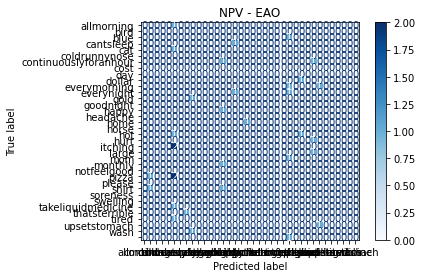

PCA inputs
       EMG0L       EMG0L     EMG0L  ...        OYR        OYR        OYR
91  0.191376 -0.00582274 -0.107532  ...          0          0          0
6   0.268096 -0.00815697 -0.145383  ...   0.346667   0.386667        0.4
41  0.267653 -0.00814352 -0.134319  ...  0.0733945  0.0642202  0.0458716
25  0.285096 -0.00867422 -0.137255  ...   0.931429   0.902857   0.902857
83  0.259256 -0.00788802 -0.128403  ...   0.508197   0.409836   0.377049
..       ...         ...       ...  ...        ...        ...        ...
63  0.339145  -0.0103187  -0.15528  ...    0.19403   0.208955   0.208955
37  0.279218 -0.00849537 -0.148879  ...   0.833333   0.833333   0.826087
60   0.27006 -0.00821674 -0.159994  ...          0          0          0
34  0.258838 -0.00787531 -0.135288  ...   0.101695   0.101695   0.101695
18   0.31821 -0.00968174 -0.161348  ...   0.626506   0.626506   0.626506

[75 rows x 1400 columns]
<class 'pandas.core.frame.DataFrame'>
        EMG0L       EMG0L     EMG0L  ...        O

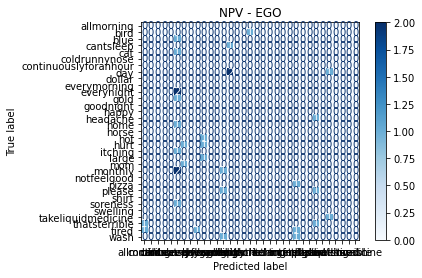

PCA inputs
          AXL        AXL        AXL  ...       OYR       OYR       OYR
33  0.0660168  0.0345404   0.216156  ...  0.578125   0.59375   0.59375
26   0.456663   0.475028   0.492274  ...   0.96648  0.944134  0.927374
60   0.114396   0.123515   0.109975  ...         0         0         0
4    0.117806   0.133993   0.125899  ...  0.474227  0.463918  0.463918
18   0.569369   0.587816   0.587432  ...  0.626506  0.626506  0.626506
..        ...        ...        ...  ...       ...       ...       ...
64   0.601984   0.594382   0.646114  ...  0.647541  0.680328  0.704918
0    0.385813   0.385398   0.419416  ...     0.896      0.84       0.8
42   0.197597   0.192702   0.145528  ...      0.75      0.75      0.75
15   0.309777   0.307555   0.313555  ...  0.463768  0.463768  0.449275
53  0.0152043  0.0159521  0.0194417  ...  0.671233  0.650685  0.636986

[75 rows x 900 columns]
<class 'pandas.core.frame.DataFrame'>
           AXL        AXL        AXL  ...        OYR        OYR        OYR

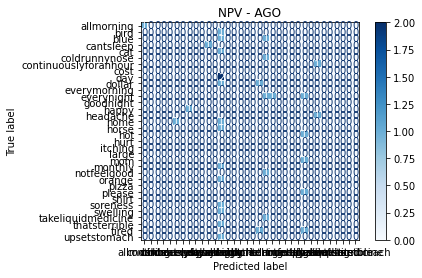

PCA inputs
        EMG0L       EMG0L     EMG0L  ...       OYR       OYR       OYR
56   0.372374  -0.0113297 -0.198861  ...  0.426667  0.426667  0.426667
99   0.294481 -0.00895976 -0.176963  ...  0.592233  0.592233  0.592233
103     0.272 -0.00827575 -0.150941  ...  0.428571  0.428571  0.428571
5    0.389963  -0.0118649 -0.215522  ...  0.872727  0.845455  0.827273
42   0.306777 -0.00933386  -0.16759  ...      0.75      0.75      0.75
..        ...         ...       ...  ...       ...       ...       ...
107  0.235771 -0.00717346 -0.128042  ...  0.792683  0.768293  0.743902
18    0.31821 -0.00968174 -0.161348  ...  0.626506  0.626506  0.626506
1    0.340417  -0.0103574 -0.185247  ...     0.712     0.672      0.64
80   0.309053 -0.00940313 -0.170118  ...  0.448718  0.448718  0.448718
33   0.277264 -0.00843592 -0.116841  ...  0.578125   0.59375   0.59375

[75 rows x 1700 columns]
<class 'pandas.core.frame.DataFrame'>
        EMG0L       EMG0L      EMG0L  ...        OYR        OYR        OY

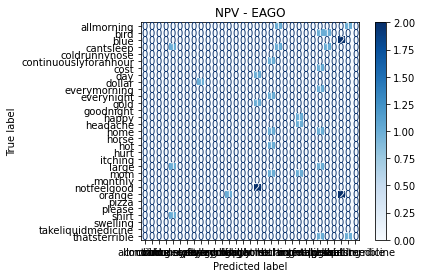

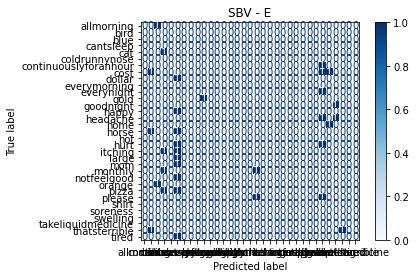

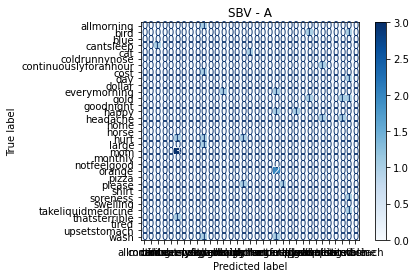

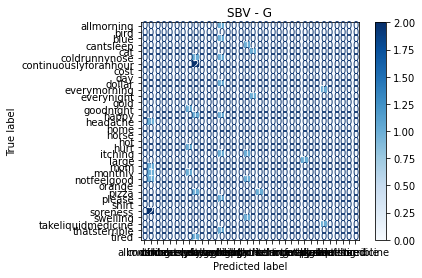

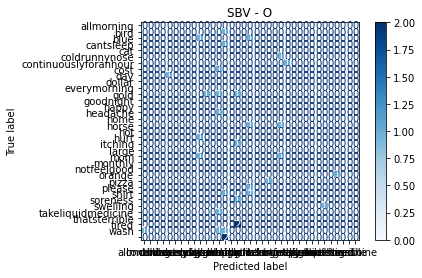

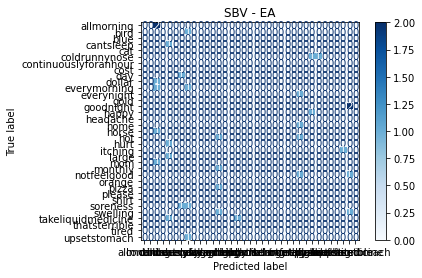

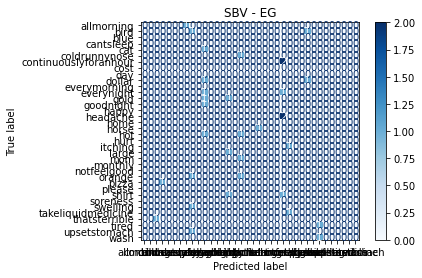

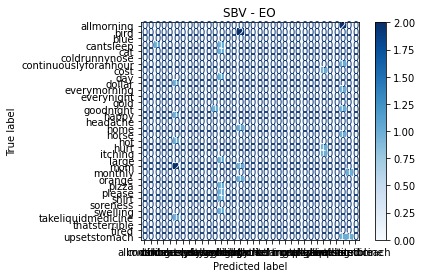

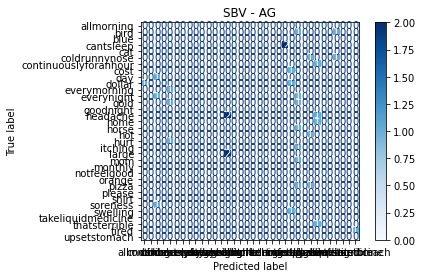

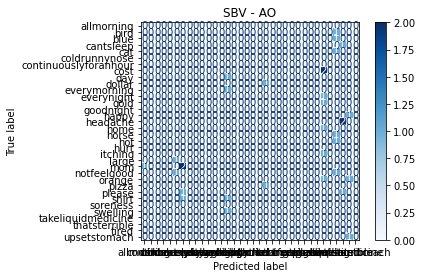

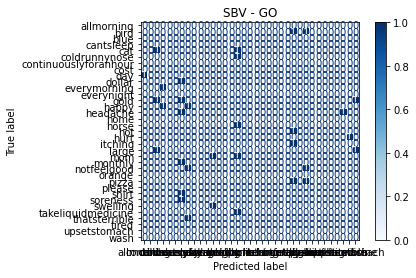

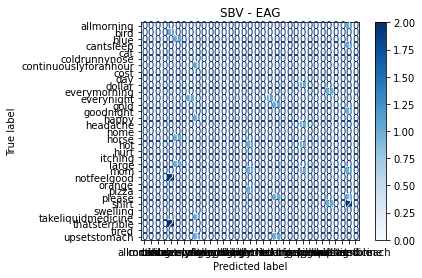

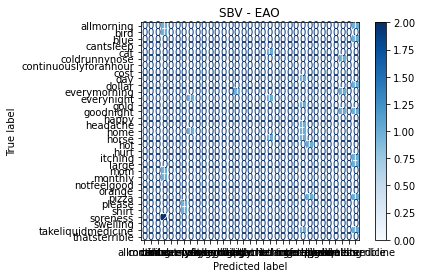

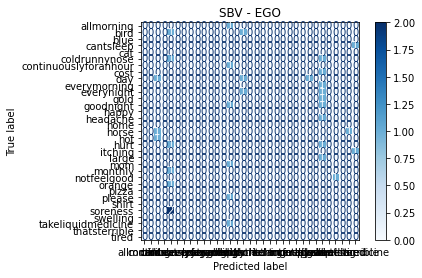

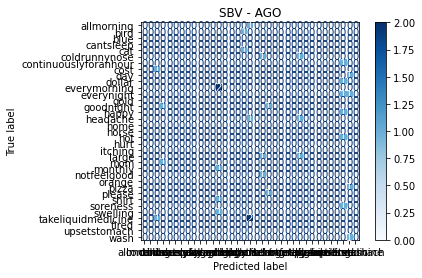

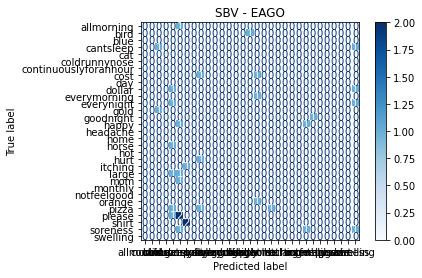

PCA inputs
          EMG0L        EMG0L       EMG0L  ...     EMG7R      EMG7R      EMG7R
37    0.0530914  -0.00161534  -0.0741681  ...  0.178745   0.465248   0.425339
58    0.0443902   -0.0013506     2.52476  ... -0.150925 -0.0297541  -0.142875
16    0.0627032  -0.00190778    0.134435  ... -0.951892   -1.05293   -1.02364
14    0.0555981  -0.00169161    0.100489  ...  0.488444   0.557186   0.407413
94   0.00728346 -0.000221604    0.169609  ...  0.420473   0.109483  0.0139966
..          ...          ...         ...  ...       ...        ...        ...
93    0.0523193  -0.00159185   0.0780835  ...  0.711343   0.435982   0.328474
105   0.0228128 -0.000694093    -1.70366  ... -0.241958  -0.172348  -0.438368
30    0.0721236   -0.0021944   -0.037697  ...  0.187274   0.392526  -0.197061
60    0.0720836  -0.00219319   -0.336985  ...  0.285184  0.0442196   0.322061
95    0.0561658  -0.00170888  0.00353728  ...  0.664679   0.594174   0.310287

[75 rows x 800 columns]
<class 'pandas.core.frame.Da

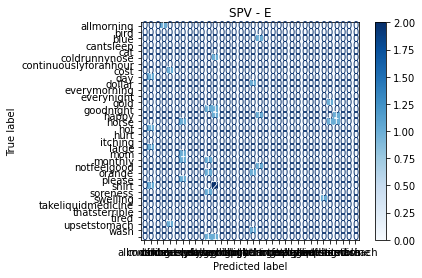

PCA inputs
         AXL        AXL        AXL  ...       AZR       AZR       AZR
90 -0.889831  -0.932742   -0.88344  ...   1.30321   1.31234   1.31873
14 -0.913135  -0.895792  -0.891711  ...    1.3588   1.44042   1.54956
86 -0.320481  -0.147476   0.121525  ...  0.411624  0.402131  0.536102
61  -1.31663   -1.33969   -1.40618  ...  0.945124   1.05329   1.02758
38 -0.442176  -0.451619  -0.431945  ...  0.945256  0.995622  0.978309
..       ...        ...        ...  ...       ...       ...       ...
57  -0.15198 -0.0126978 -0.0505166  ...   1.02499   1.03237   1.03145
77 -0.587211  -0.595099  -0.572309  ...  0.823147  0.962517  0.999331
46  -1.52444   -1.13545   -1.04866  ...  0.869079   1.15036   1.23088
70  -1.71633   -1.78652    -1.6632  ...   1.29649   1.39174   1.63136
36  0.486925   0.481311   0.499088  ...   1.16333    1.1755    1.1783

[75 rows x 300 columns]
<class 'pandas.core.frame.DataFrame'>
           AXL        AXL        AXL  ...       AZR         AZR        AZR
98    -1.10

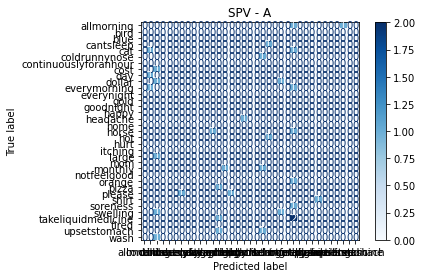

PCA inputs
           GXL         GXL         GXL  ...          GZR        GZR        GZR
13   0.0279427    0.071664   0.0221131  ...    0.0386301  0.0366869  0.0366869
81   -0.515606   -0.363543   -0.185596  ...     -2.20664   -1.93162   -1.39779
18   0.0015452    0.293593     1.09525  ...  -0.00629501 -0.0905773 -0.0366758
66  -0.0452973 -0.00770106 -0.00770106  ...    0.0449337  0.0524529  0.0242557
17  -0.0262859  -0.0475522   0.0401712  ...  0.000296913 -0.0103362 -0.0289442
..         ...         ...         ...  ...          ...        ...        ...
64    0.885605    0.894709     1.50874  ...      2.11772    1.91742     1.8284
84    -1.24457   -0.181222     1.08198  ...  -0.00431603  -0.191741  -0.151579
76  -0.0481075  -0.0993446  -0.0497604  ... -0.000176079  0.0956869   0.145271
101 -0.0169556   -0.585141   -0.786655  ...     -1.04011  -0.806391  -0.721215
96    0.101333    -0.10117   0.0059005  ...   -0.0138843 -0.0173758  0.0187024

[75 rows x 300 columns]
<class 'pandas.c

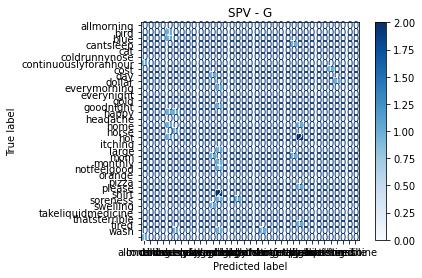

PCA inputs
          ORL        ORL       ORL  ...       OYR       OYR       OYR
66   0.643803   0.643803  0.643803  ...  -1.20176  -1.20176  -1.20176
90  -0.278431  -0.209341 -0.209341  ...  -0.41661  -0.41661  -0.41661
9   -0.640867  -0.731215 -0.776389  ...   1.12092   1.07574   1.07574
42  -0.528673  -0.528673 -0.420891  ...  0.495261  0.495261  0.495261
52  -0.316735  -0.316735 -0.342521  ... -0.806665  -0.78088  -0.78088
..        ...        ...       ...  ...       ...       ...       ...
94 -0.0375259  -0.194977 -0.352428  ...   1.45826   1.85189   2.08807
58   0.466765   0.375183  0.192018  ... -0.357477 -0.357477 -0.357477
10  0.0663099  0.0083129 -0.107681  ... -0.397666  -0.51366 -0.687651
97  -0.478096  -0.478096 -0.478096  ...  0.440973   0.38691   0.38691
21  -0.904322  -0.941924 -0.979526  ...  -1.01713  -1.01713  -1.01713

[75 rows x 300 columns]
<class 'pandas.core.frame.DataFrame'>
           ORL        ORL        ORL  ...         OYR        OYR        OYR
78    -1.2

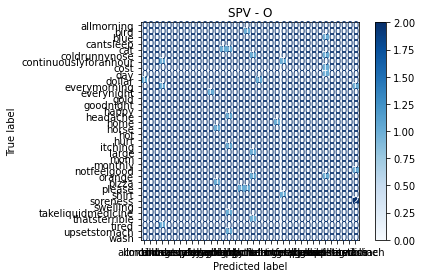

PCA inputs
        EMG0L        EMG0L       EMG0L  ...       AZR       AZR       AZR
28  0.0941077  -0.00286328  -0.0491875  ...   1.45079   1.38924   1.54652
6   0.0491789   -0.0014963   -0.112363  ...   1.12473   3.31999   1.89709
56  0.0900761  -0.00274062   -0.105476  ...  0.637179  0.939022   1.12756
68 -0.0317201  0.000965103  -0.0914041  ...   1.05648   1.04277   1.10275
72  0.0295758 -0.000899862  -0.0810005  ...   1.54046   1.41773   1.39265
..        ...          ...         ...  ...       ...       ...       ...
46  0.0719459    -0.002189   -0.630972  ...  0.869079   1.15036   1.23088
49  0.0317891 -0.000967202   -0.408727  ...   1.36308    1.3651   1.33085
47  0.0255783 -0.000778236    -0.13165  ...  0.843918  0.846585  0.852811
82  0.0786617  -0.00239333    0.083252  ...   1.27338   1.28774   1.43132
87  0.0577928  -0.00175838  0.00924231  ...   1.19808   1.10751   1.51754

[75 rows x 1100 columns]
<class 'pandas.core.frame.DataFrame'>
          EMG0L        EMG0L       EM

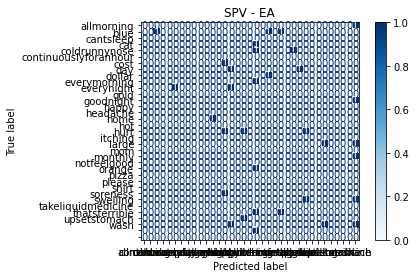

PCA inputs
        EMG0L        EMG0L       EMG0L  ...         GZR         GZR         GZR
77  0.0235881 -0.000717683  -0.0437797  ... -0.00995231  -0.0509383  -0.0110032
35  0.0416979  -0.00126868   -0.125231  ...  -0.0498112  -0.0415723  -0.0429455
79  0.0744919  -0.00226646   -0.145162  ... -0.00834836    0.664888     1.10343
70  0.0443128  -0.00134824    0.145329  ...    0.305956 -0.00264886   -0.155849
86  0.0149167  -0.00045385   0.0321144  ...    -1.46188    -1.60584    -1.68914
..        ...          ...         ...  ...         ...         ...         ...
72  0.0295758 -0.000899862  -0.0810005  ...    0.403215  -0.0592765  -0.0705069
58  0.0443902   -0.0013506     2.52476  ...   0.0770208  -0.0443684   0.0862169
95  0.0561658  -0.00170888  0.00353728  ...    0.911795   -0.317588   -0.969145
14  0.0555981  -0.00169161    0.100489  ...   0.0761992   -0.229125  -0.0511223
3   0.0538262  -0.00163769  -0.0787338  ...   -0.136774  -0.0549075 -0.00828905

[75 rows x 1100 columns]
<cl

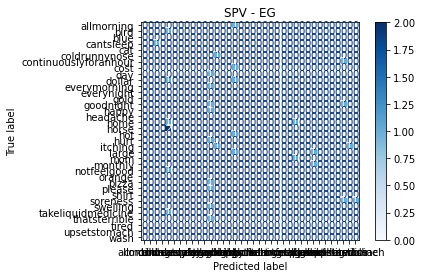

PCA inputs
          EMG0L        EMG0L       EMG0L  ...        OYR        OYR        OYR
76     0.015124 -0.000460158   0.0217501  ...   -1.12863   -1.12863   -1.12863
19    0.0653918  -0.00198958   -0.176412  ...    0.84622    0.84622    0.84622
53    0.0746453  -0.00227113   -0.149806  ...   0.616572   0.544552   0.496538
50    0.0736443  -0.00224067  -0.0935016  ...  0.0705071  0.0705071  0.0705071
48     0.123101  -0.00374544   -0.157866  ...   0.269485   0.300154   0.300154
..          ...          ...         ...  ...        ...        ...        ...
74    0.0343794  -0.00104601   0.0822257  ...   -1.41836   -1.41836    -1.4436
101  0.00414625 -0.000126152 -0.00216713  ...  -0.776134  -0.776134  -0.826784
62    0.0769975  -0.00234269   -0.295485  ...    -1.7695    -1.7695    -1.7695
35    0.0416979  -0.00126868   -0.125231  ...   -0.67727   -0.67727   -0.67727
28    0.0941077  -0.00286328  -0.0491875  ...      2.045    2.01787    1.99074

[75 rows x 1100 columns]
<class 'pandas.

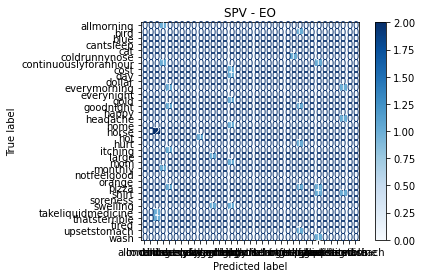

PCA inputs
          AXL       AXL       AXL  ...          GZR        GZR        GZR
17   -1.27113  -1.27283   -1.2499  ...  0.000296913 -0.0103362 -0.0289442
33   -1.66176  -1.77512  -1.12105  ...    -0.641829  -0.886065  -0.491051
102 -0.723671 -0.716077 -0.742238  ...    -0.160208  -0.229087  -0.179494
27  -0.439976 -0.460558 -0.225926  ...    0.0509766  0.0458601   0.059504
32   -1.01321  -1.00171 -0.859537  ...    -0.866111  -0.688539  -0.508087
..        ...       ...       ...  ...          ...        ...        ...
7   -0.398382 -0.398382 -0.403568  ...     -1.69485    -2.5171   -3.19011
0     -1.0229  -1.02468 -0.877987  ...     -2.62399   -3.34237   -3.55977
2   -0.257177 -0.604246 -0.245412  ...    0.0316758 -0.0220337   0.063326
18     0.1906  0.287122  0.285112  ...  -0.00629501 -0.0905773 -0.0366758
11    -1.6444  -1.63867  -1.61861  ...     -1.81637   -2.39016   -2.10375

[75 rows x 600 columns]
<class 'pandas.core.frame.DataFrame'>
         AXL       AXL       AXL  ... 

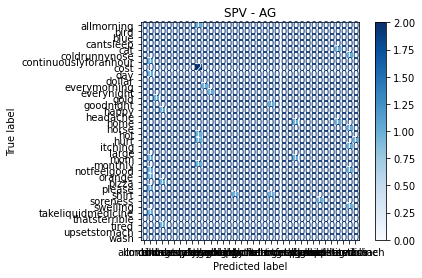

PCA inputs
         AXL       AXL       AXL  ...       OYR       OYR       OYR
89  0.142403 -0.199324 -0.631284  ... -0.708795 -0.708795 -0.646051
54  -1.04281  -1.05946  -1.05724  ...  -2.36596  -2.36596  -2.36596
3    -1.2187  -1.22123  -1.27613  ...  0.524493  0.483971  0.483971
39  -2.04385  -2.04866  -1.83794  ...  0.955416  0.955416  0.917189
13 -0.995956  -1.00355  -1.02296  ... -0.141255 -0.141255 -0.141255
..       ...       ...       ...  ...       ...       ...       ...
75  -1.32317  -1.32485  -1.32149  ...  0.516441  0.476623  0.396987
1   -1.10529  -1.12642 -0.727572  ...  0.529035   0.34192  0.192229
80  -1.13763  -1.14251  -1.13844  ...  -0.18579  -0.18579  -0.18579
97  -1.11864  -1.10653  -1.02779  ...  0.440973   0.38691   0.38691
61  -1.31663  -1.33969  -1.40618  ...  -1.80953  -1.80953  -1.86854

[75 rows x 600 columns]
<class 'pandas.core.frame.DataFrame'>
           AXL         AXL        AXL  ...         OYR        OYR        OYR
53     -1.0759     -1.0734   -1.0

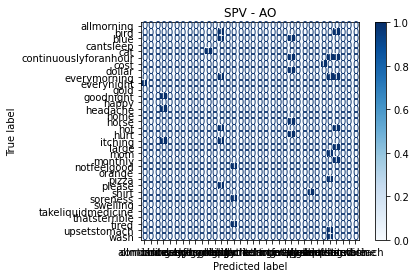

PCA inputs
            GXL         GXL          GXL  ...        OYR        OYR        OYR
61    0.0838119   0.0547567  -0.00698551  ...   -1.80953   -1.80953   -1.86854
48  2.08692e-05  0.00361488  0.000919372  ...   0.269485   0.300154   0.300154
19     -1.02287    -1.22379     0.190249  ...    0.84622    0.84622    0.84622
89     0.552256     1.16535    -0.392443  ...  -0.708795  -0.708795  -0.646051
8      0.081686   0.0460855    0.0282852  ...   -2.15961   -2.23619   -2.28724
..          ...         ...          ...  ...        ...        ...        ...
38    -0.016007  -0.0116972   -0.0364781  ...   -1.64381   -1.64381   -1.64381
59    0.0520076    0.074362   0.00933107  ...    2.09773    2.04219    2.01442
50     0.014097 -0.00722963   0.00983164  ...  0.0705071  0.0705071  0.0705071
1      0.106795    0.181877     -1.04299  ...   0.529035    0.34192   0.192229
18    0.0015452    0.293593      1.09525  ...   0.447235   0.447235   0.447235

[75 rows x 600 columns]
<class 'pandas.c

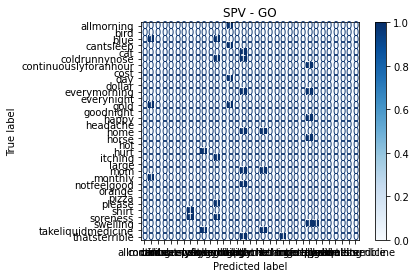

PCA inputs
         EMG0L        EMG0L      EMG0L  ...        GZR        GZR         GZR
71   0.0564807  -0.00171846  -0.945901  ...   -1.34023   -1.15215    -1.08877
89   0.0143226 -0.000435773 -0.0905154  ...  -0.247595    0.06032  -0.0954597
20  0.00198873 -6.05083e-05   0.368296  ...  -0.154275  -0.442739   -0.728281
83   0.0867611  -0.00263976  0.0648252  ...   -3.33596   -2.58638    -2.24379
58   0.0443902   -0.0013506    2.52476  ...  0.0770208 -0.0443684   0.0862169
..         ...          ...        ...  ...        ...        ...         ...
10   0.0098909 -0.000300937  -0.262076  ...  -0.693061   -1.15886    -1.94451
2     0.104536  -0.00318056  -0.130286  ...  0.0316758 -0.0220337    0.063326
0    0.0580938  -0.00176754  -0.417119  ...   -2.62399   -3.34237    -3.55977
3    0.0538262  -0.00163769 -0.0787338  ...  -0.136774 -0.0549075 -0.00828905
60   0.0720836  -0.00219319  -0.336985  ...  -0.146922  -0.144642   -0.030676

[75 rows x 1400 columns]
<class 'pandas.core.frame.D

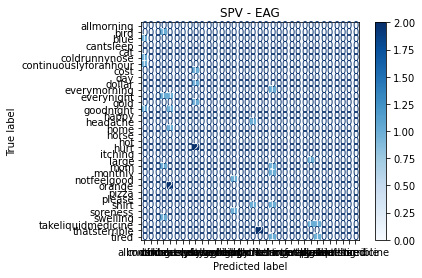

PCA inputs
        EMG0L        EMG0L      EMG0L  ...         OYR        OYR        OYR
53  0.0746453  -0.00227113  -0.149806  ...    0.616572   0.544552   0.496538
76   0.015124 -0.000460158  0.0217501  ...    -1.12863   -1.12863   -1.12863
50  0.0736443  -0.00224067 -0.0935016  ...   0.0705071  0.0705071  0.0705071
92  0.0535658  -0.00162977  -0.449776  ...    -1.95225   -1.95225   -1.95225
18  0.0262655 -0.000799143  0.0333847  ...    0.447235   0.447235   0.447235
..        ...          ...        ...  ...         ...        ...        ...
77  0.0235881 -0.000717683 -0.0437797  ...    -2.02668   -2.02668   -2.02668
30  0.0721236   -0.0021944  -0.037697  ...   -0.147833  -0.147833  -0.147833
4   0.0336447  -0.00102366  -0.759475  ... -0.00584232 -0.0416116 -0.0416116
73  0.0575522  -0.00175106 -0.0300809  ...   -0.329191  -0.462827  -0.462827
99 -0.0116305  0.000353864  -0.299539  ...    0.114515   0.114515   0.114515

[75 rows x 1400 columns]
<class 'pandas.core.frame.DataFrame'>
 

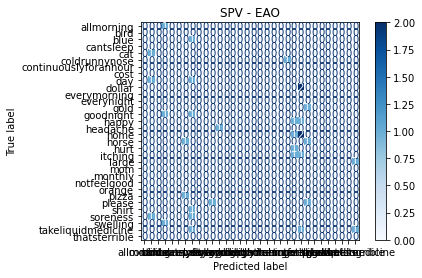

PCA inputs
         EMG0L        EMG0L      EMG0L  ...       OYR       OYR        OYR
81   0.0190152  -0.00057855  -0.191903  ...  0.583011   0.32916  0.0753091
8    0.0459405  -0.00139777 -0.0240119  ...  -2.15961  -2.23619   -2.28724
10   0.0098909 -0.000300937  -0.262076  ... -0.397666  -0.51366  -0.687651
11   0.0243209 -0.000739979  -0.044556  ...  0.276333  0.172449   0.120506
72   0.0295758 -0.000899862 -0.0810005  ...   -0.3357   -0.3357    -0.3357
..         ...          ...        ...  ...       ...       ...        ...
91   0.0364421  -0.00110877   -0.14337  ...  -2.04419  -2.04419   -2.04419
27   0.0116231 -0.000353641  -0.328301  ...  -1.48468  -1.48468   -1.48468
88   0.0574078  -0.00174667  -0.100445  ... -0.718118 -0.718118  -0.718118
107  0.0359929   -0.0010951 -0.0678658  ...  0.940625  0.855629   0.770633
24   0.0408737  -0.00124361   0.110487  ...  -1.70394  -1.70394   -1.70394

[75 rows x 1400 columns]
<class 'pandas.core.frame.DataFrame'>
          EMG0L        EM

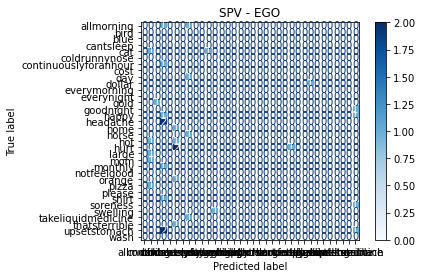

PCA inputs
           AXL         AXL        AXL  ...       OYR       OYR       OYR
107   -1.08614    -1.08175  -0.756864  ...  0.940625  0.855629  0.770633
65    0.840803    0.859595   0.912394  ...   2.03727   2.00964     1.982
10   -0.543265   -0.123791   0.138518  ... -0.397666  -0.51366 -0.687651
85   -0.777501   -0.774777  -0.781133  ...  0.845402  0.845402  0.804842
106  0.0738868 -0.00746806 -0.0956734  ... -0.956788 -0.956788 -0.956788
..         ...         ...        ...  ...       ...       ...       ...
84   -0.642777    0.356745   0.797831  ... -0.272546 -0.272546 -0.272546
23   -0.208777   -0.174349  -0.152217  ... -0.989215 -0.989215 -0.989215
61    -1.31663    -1.33969   -1.40618  ...  -1.80953  -1.80953  -1.86854
82    -0.68612   -0.690342  -0.675983  ...   1.01486  0.725728  0.378766
54    -1.04281    -1.05946   -1.05724  ...  -2.36596  -2.36596  -2.36596

[75 rows x 900 columns]
<class 'pandas.core.frame.DataFrame'>
           AXL        AXL        AXL  ...       OY

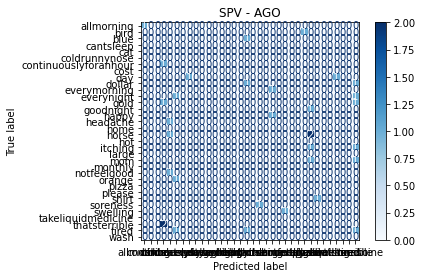

PCA inputs
         EMG0L        EMG0L      EMG0L  ...       OYR       OYR        OYR
25   0.0541465  -0.00164744  0.0923599  ...   1.97572   1.84347    1.84347
71   0.0564807  -0.00171846  -0.945901  ... -0.758252 -0.783116  -0.807979
39   0.0368301  -0.00112058  -0.149911  ...  0.955416  0.955416   0.917189
63   0.0545331   -0.0016592   0.318526  ...  -1.31138  -1.24009   -1.24009
66  0.00602318 -0.000183259   -0.14487  ...  -1.20176  -1.20176   -1.20176
..         ...          ...        ...  ...       ...       ...        ...
99  -0.0116305  0.000353864  -0.299539  ...  0.114515  0.114515   0.114515
5    0.0793463  -0.00241416  -0.220617  ...   1.21192    1.1243    1.06589
44    0.025718 -0.000782486 -0.0134421  ...  -1.76244    -1.804   -1.84556
81   0.0190152  -0.00057855  -0.191903  ...  0.583011   0.32916  0.0753091
78   0.0809426  -0.00246273 -0.0423065  ...   1.14864   1.14864    1.18258

[75 rows x 1700 columns]
<class 'pandas.core.frame.DataFrame'>
          EMG0L        EM

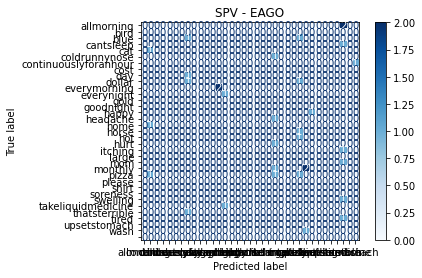

PCA inputs
    EMG0L EMG0L     EMG0L      EMG0L  ...     EMG7R     EMG7R     EMG7R      EMG7R
0       0     0  -2.13591    12.9454  ...   -4.9183 -0.967757  -0.60474   -2.79709
104     0     0         0    2.13591  ...   -7.4853   1.66241   9.69337     3.1459
32      0     0  0.355984   -1.80158  ...  0.260662 -0.901343  0.248122  -0.171662
50      0     0 -0.355984  -0.690306  ...  -2.41788   -2.8129   5.39951    4.55684
68      0     0 -0.711968  0.0433241  ...  -7.71387  -3.35616   1.22916  -0.771453
..    ...   ...       ...        ...  ...       ...       ...       ...        ...
80      0     0 -0.711968    2.17923  ...  -5.06783  -2.61779  -6.49745    4.01508
101     0     0         0  -0.355984  ...   10.4095  -2.61237  -18.8729   -12.3712
106     0     0  -1.06795    2.91286  ...  0.644689   -2.2107  -1.53082   -1.80343
28      0     0         0  -0.355984  ...  -1.20779 -0.221862 -0.935573   -1.76311
10      0     0  -1.77992   0.464295  ... -0.790769  -5.48474  -2.16989  0.0

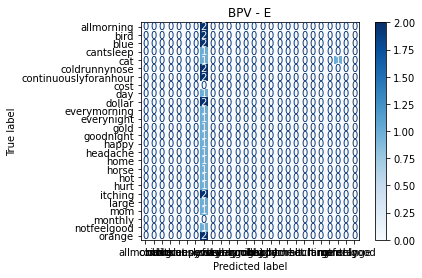

PCA inputs
          AXL        AXL        AXL  ...       AZR       AZR       AZR
93  -0.599609  -0.590332  -0.583008  ...   1.05322  0.722168  0.721191
77  -0.140137  -0.144531  -0.131836  ...  0.645508  0.723145  0.743652
7  -0.0493164 -0.0493164 -0.0522461  ...  0.861816  0.937988   1.01416
58  -0.121582  -0.194336  -0.349121  ...   1.13623  0.934082   1.02588
63  -0.176758  -0.161621  -0.231934  ...   0.90918  0.988281  0.757324
..        ...        ...        ...  ...       ...       ...       ...
13  -0.434082  -0.438477  -0.449707  ...  0.841797  0.828613   0.82666
1   -0.391602   -0.40332  -0.182129  ...  0.851074  0.925293  0.954102
86   0.196289   0.276367   0.400879  ...  0.535156  0.530762  0.592773
55 -0.0615234 -0.0620117 -0.0712891  ...   1.00781  0.969727  0.946289
23 -0.0629883 -0.0424805 -0.0292969  ...  0.798828  0.811523  0.791016

[75 rows x 300 columns]
<class 'pandas.core.frame.DataFrame'>
           AXL        AXL        AXL  ...       AZR        AZR        AZR


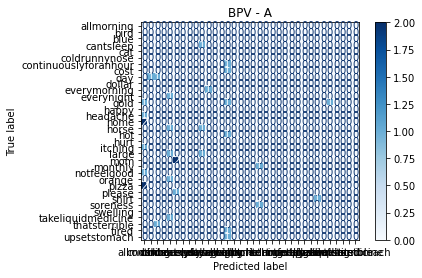

PCA inputs
        GXL      GXL      GXL      GXL  ...      GZR      GZR      GZR      GZR
86  18.5625    21.25  54.6875   63.375  ... -75.1875  -89.375  -98.125 -103.188
96   4.9375  -5.9375  -0.1875       -3  ...   -1.125    -1.25  -1.4375      0.5
25  -20.625   -40.75 -97.8125 -163.312  ... -231.812 -181.688  -76.625 -24.4375
40  15.9375  43.9375  19.5625   -28.25  ...       15   6.4375  -1.4375   5.6875
39   -4.625  18.4375     52.5   18.625  ...        0        0  -0.3125  -0.4375
..      ...      ...      ...      ...  ...      ...      ...      ...      ...
7         0   -0.375    1.125   2.3125  ...  -40.125 -74.4375 -112.312 -143.312
31  -18.125   -35.75  51.3125   9.9375  ...  -3.4375 -10.8125  -3.6875   -1.625
42  36.5625  27.0625  71.0625  66.9375  ...        5  -1.9375   9.8125    8.625
15     1.25   0.1875     8.75  24.8125  ... -31.6875  -23.625  -25.875  -23.375
65  -0.5625    -2.25  34.5625  14.1875  ...   36.375     6.25     2.75   0.1875

[75 rows x 300 columns]
<cla

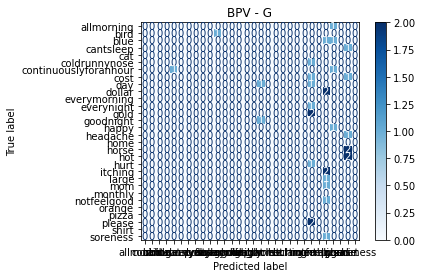

PCA inputs
    ORL  ORL  ORL  ORL  ORL  ORL  ORL  ...  OYR  OYR  OYR  OYR  OYR  OYR  OYR
72   88   88   88   88   90   88   88  ...   84   82   81   81   81   81   81
74   78   78   78   78   78   78   78  ...   47   47   47   47   47   47   46
17   83   83   83   83   83   83   83  ...   11   11   11   11   11   11   11
65  101  101  102  103  103  104  105  ...  167  169  170  171  171  170  169
23   66   66   66   66   66   67   67  ...   75   75   75   75   75   75   75
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
78   61   61   61   61   61   61   61  ...  137  135  133  131  131  131  132
3    85   85   86   86   87   87   87  ...  125  125  125  125  125  124  124
37   62   62   62   62   62   62   61  ...  155  154  154  154  154  154  153
51   87   87   87   87   87   87   87  ...   14   14   14   14   14   14   14
11   82   82   82   82   81   81   80  ...   97   97   97   97   97   95   94

[75 rows x 300 columns]
<class 'pandas.core.frame.Da

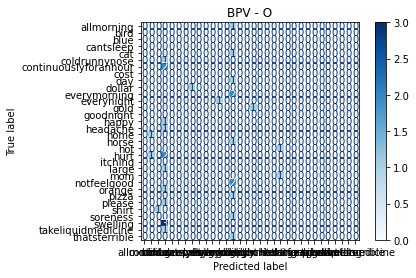

PCA inputs
   EMG0L EMG0L     EMG0L     EMG0L  ...       AZR       AZR       AZR       AZR
80     0     0 -0.711968   2.17923  ...  0.808594    0.6875  0.720703  0.763672
82     0     0   1.06795  -3.26884  ...  0.910156  0.876465  0.884766  0.967773
26     0     0 -0.355984  0.377646  ...  0.467773  0.400391  0.283203   0.23584
14     0     0   1.06795  -3.62483  ...   1.16895  0.990723   1.02979   1.08203
57     0     0   7.47567  -12.9144  ...  0.812012  0.798828  0.802734  0.802246
..   ...   ...       ...       ...  ...       ...       ...       ...       ...
74     0     0  0.711968   -2.8912  ...  0.751465  0.818848  0.808105  0.832031
46     0     0  -3.55984   7.33631  ...  0.724121  0.764648  0.895996  0.933594
92     0     0  -1.77992   1.88823  ...  0.961914  0.963867  0.965332  0.958984
48     0     0 -0.355984  0.733631  ...   1.11768  0.723633  0.747559  0.756836
52     0     0 -0.355984  0.733631  ...   1.23096   1.26855   1.20654   1.20654

[75 rows x 1100 columns]
<cl

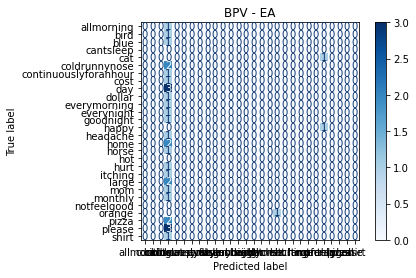

PCA inputs
   EMG0L EMG0L     EMG0L      EMG0L  ...      GZR      GZR      GZR      GZR
44     0     0         0          0  ...  -61.375  -38.125  -44.625  -40.375
18     0     0  0.711968   -5.73907  ...   14.375   0.1875  -5.1875    -1.75
5      0     0  -1.06795    1.48892  ...   -73.75 -68.1875 -95.0625 -90.6875
68     0     0 -0.711968  0.0433241  ...  -2.9375  -2.9375   -5.125      0.5
12     0     0 -0.355984   0.377646  ...     0.25   2.9375      1.5   -0.375
..   ...   ...       ...        ...  ...      ...      ...      ...      ...
10     0     0  -1.77992   0.464295  ... -13.3125 -43.3125 -72.4375 -121.562
78     0     0         0    1.06795  ... -63.1875  -43.875    -11.5    2.625
60     0     0  -1.06795    2.55688  ...   -6.375   -7.375    -7.25       -1
33     0     0   2.84787   -12.9887  ... -36.9375 -32.1875 -44.4375  -24.625
40     0     0  0.711968   -2.17923  ...       15   6.4375  -1.4375   5.6875

[75 rows x 1100 columns]
<class 'pandas.core.frame.DataFrame'>
 

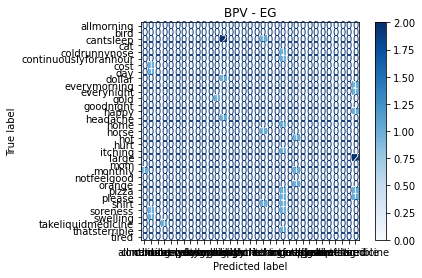

PCA inputs
   EMG0L EMG0L     EMG0L     EMG0L     EMG0L  ...  OYR  OYR  OYR  OYR  OYR
62     0     0  -1.06795   2.20089 -0.082535  ...   68   68   68   68   68
72     0     0 -0.711968   1.46726 -0.766992  ...   81   81   81   81   81
9      0     0    6.7637  -11.8031  -2.81111  ...  118  115  113  112  112
38     0     0         0 -0.711968  0.755293  ...   20   19   19   19   19
44     0     0         0         0  -1.06795  ...   40   40   38   37   36
..   ...   ...       ...       ...       ...  ...  ...  ...  ...  ...  ...
10     0     0  -1.77992  0.464295   7.17708  ...   81   80   78   76   73
75     0     0 -0.355984  0.733631  0.328473  ...  130  128  126  125  123
43     0     0         0 -0.355984 -0.334322  ...   66   65   65   65   65
27     0     0  -2.49189   5.13541   3.36726  ...   43   43   43   43   43
98     0     0 -0.355984  0.377646  0.350135  ...   23   23   23   23   23

[75 rows x 1100 columns]
<class 'pandas.core.frame.DataFrame'>
    EMG0L EMG0L     EMG0L

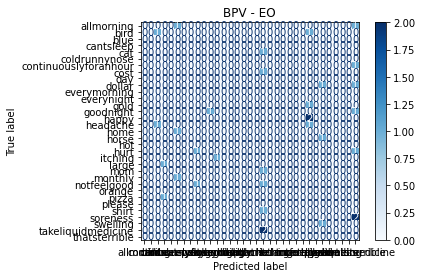

PCA inputs
         AXL       AXL        AXL  ...      GZR      GZR      GZR
46 -0.353027 -0.171387  -0.130859  ...  -101.75  -70.125 -45.3125
38 -0.180664 -0.186523  -0.174316  ...    -2.25    -0.25      1.5
10  0.153809  0.342773   0.460938  ... -43.3125 -72.4375 -121.562
89  0.411133  0.237305  0.0175781  ...  -7.1875  13.9375     3.25
77 -0.140137 -0.144531  -0.131836  ...   0.5625   -1.875      0.5
..       ...       ...        ...  ...      ...      ...      ...
0  -0.319336 -0.320312  -0.240234  ... -189.188 -241.438  -257.25
5  -0.591797 -0.600098   -0.59082  ... -68.1875 -95.0625 -90.6875
65  0.668457  0.678711    0.70752  ...     6.25     2.75   0.1875
50  -0.35498 -0.343262  -0.351074  ...  -16.625    -5.25     3.25
93 -0.599609 -0.590332  -0.583008  ...  -6.1875   2.8125 -28.5625

[75 rows x 600 columns]
<class 'pandas.core.frame.DataFrame'>
           AXL        AXL         AXL  ...      GZR      GZR      GZR
73   -0.522461   -0.23291   -0.350586  ... -143.188 -41.0625  -5

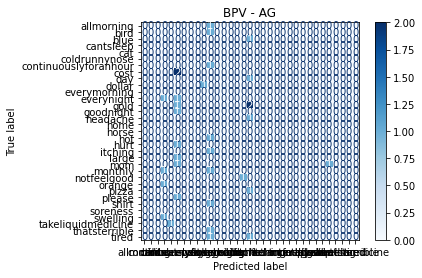

PCA inputs
          AXL        AXL        AXL          AXL  ...  OYR  OYR  OYR  OYR
81  -0.210938  -0.196289 -0.0678711    -0.243164  ...  108  105  101   97
58  -0.121582  -0.194336  -0.349121    -0.260742  ...   77   77   77   77
17  -0.570801  -0.571777  -0.558594    -0.553223  ...   11   11   11   11
69  -0.317871  -0.313477  -0.418945    -0.381836  ...  102  100   97   95
48   -0.44873   -0.45166  -0.444824    -0.445312  ...  103  103  104  104
..        ...        ...        ...          ...  ...  ...  ...  ...  ...
23 -0.0629883 -0.0424805 -0.0292969  0.000976562  ...   75   75   75   75
66 -0.0878906 -0.0869141 -0.0522461    -0.065918  ...   21   21   21   21
25   0.736816    0.47998  0.0214844   -0.0219727  ...  178  166  161  161
95  -0.555664  -0.562988  -0.500977    -0.485352  ...   53   57   57   55
14 -0.0966797 -0.0883789 -0.0864258   -0.0844727  ...   76   77   76   76

[75 rows x 600 columns]
<class 'pandas.core.frame.DataFrame'>
           AXL        AXL         AXL 

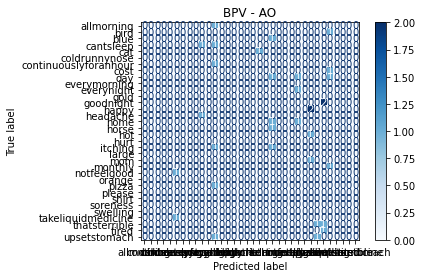

PCA inputs
        GXL      GXL      GXL      GXL      GXL  ...  OYR  OYR  OYR  OYR  OYR
4     -1.75  -3.6875  -1.4375   0.5625  -1.1875  ...   92   92   92   91   91
97  -20.625 -11.4375       14   22.375     20.5  ...  101  101  101  100  100
56  -0.1875    0.875   0.1875    -0.25   -2.375  ...   84   84   84   84   84
35   -28.25 -53.0625      -81       19  15.3125  ...   55   55   55   55   55
84  -79.625  -10.125  72.4375  90.9375       98  ...   67   67   67   67   67
..      ...      ...      ...      ...      ...  ...  ...  ...  ...  ...  ...
76    -0.25  -2.1875  -0.3125  -0.8125        0  ...   71   71   71   71   71
33  27.1875  33.1875  -2.5625   -8.125 -11.3125  ...   89   90   91   92   92
21 -79.0625      -87  24.3125   3.9375   41.875  ...   69   69   69   69   69
81      -27 -18.1875   -7.875 -10.4375  -14.875  ...  112  108  105  101   97
61   4.9375   3.4375     0.25   8.4375  -2.3125  ...   68   68   68   68   67

[75 rows x 600 columns]
<class 'pandas.core.frame.Da

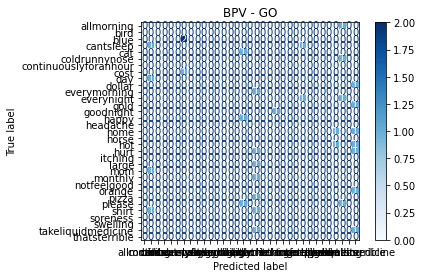

PCA inputs
   EMG0L EMG0L     EMG0L      EMG0L  ...      GZR      GZR      GZR      GZR
39     0     0 -0.711968    1.11128  ...        0        0  -0.3125  -0.4375
19     0     0  -1.77992    4.02414  ... -15.0625 -21.0625  -0.1875  -1.3125
35     0     0 -0.711968    1.46726  ...   1.5625   0.0625   0.8125   0.6875
59     0     0  -3.55984     5.2004  ... -65.1875 -60.9375  -47.125 -41.6875
88     0     0 -0.711968    1.11128  ...  10.4375   23.875  -3.0625  -4.3125
..   ...   ...       ...        ...  ...      ...      ...      ...      ...
38     0     0         0  -0.711968  ...  -0.8125    -2.25    -0.25      1.5
30     0     0         0   -1.42394  ...  -8.6875  -5.1875  -1.5625  -0.9375
31     0     0 -0.355984  0.0216621  ...  -3.4375 -10.8125  -3.6875   -1.625
89     0     0 -0.711968     5.0271  ...    -7.75  -7.1875  13.9375     3.25
75     0     0 -0.355984   0.733631  ... -48.6875 -51.0625 -30.3125 -47.3125

[75 rows x 1400 columns]
<class 'pandas.core.frame.DataFrame'>
 

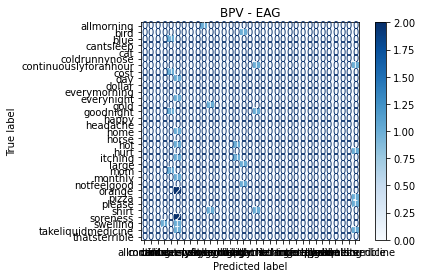

PCA inputs
   EMG0L EMG0L     EMG0L     EMG0L     EMG0L  ...  OYR  OYR  OYR  OYR  OYR
88     0     0 -0.711968   1.11128   1.39058  ...   73   73   73   73   73
22     0     0 -0.355984 -0.334322  0.749443  ...   41   41   40   40   40
7      0     0 -0.355984 -0.334322    1.8174  ...    9    8    7    4    0
89     0     0 -0.711968    5.0271  -16.6469  ...   74   73   73   73   74
67     0     0 -0.711968  0.755293   1.05625  ...  150  149  147  146  146
..   ...   ...       ...       ...       ...  ...  ...  ...  ...  ...  ...
86     0     0  0.355984  -2.51355   3.33968  ...  177  174  170  165  162
5      0     0  -1.06795   1.48892   1.02874  ...  143  140  137  134  132
65     0     0  0.355984  -2.51355   3.33968  ...  170  171  171  170  169
62     0     0  -1.06795   2.20089 -0.082535  ...   68   68   68   68   68
64     0     0  0.355984  -2.15757   1.18211  ...  118  122  125  129  132

[75 rows x 1400 columns]
<class 'pandas.core.frame.DataFrame'>
    EMG0L EMG0L     EMG0L

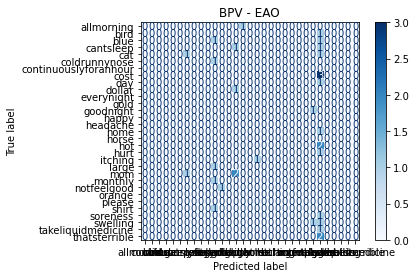

PCA inputs
   EMG0L EMG0L     EMG0L     EMG0L       EMG0L  ...  OYR  OYR  OYR  OYR  OYR
49     0     0  -2.49189   1.93156     6.76608  ...   14   14   14   14   14
99     0     0  -3.20386   7.31464    -1.71487  ...   84   84   84   84   84
62     0     0  -1.06795   2.20089   -0.082535  ...   68   68   68   68   68
47     0     0  -1.06795   2.55688     1.31974  ...   45   45   46   46   46
24     0     0  0.711968  -1.82325   0.0766854  ...    8    8    8    8    8
..   ...   ...       ...       ...         ...  ...  ...  ...  ...  ...  ...
55     0     0 -0.355984  0.377646 -0.00584961  ...  155  154  153  152  150
40     0     0  0.711968  -2.17923     1.87827  ...  111  111  111  111  111
39     0     0 -0.711968   1.11128     1.39058  ...  116  116  116  116  115
70     0     0   1.77992  -14.7037     22.5241  ...   98   99   99   99   99
17     0     0  -1.42394   1.86657    0.310924  ...   11   11   11   11   11

[75 rows x 1400 columns]
<class 'pandas.core.frame.DataFrame'>
 

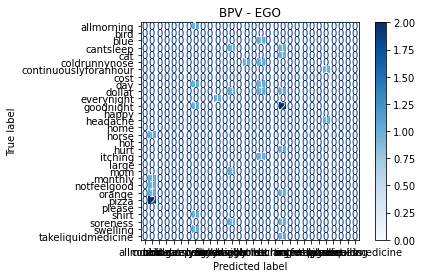

PCA inputs
          AXL        AXL        AXL        AXL  ...  OYR  OYR  OYR  OYR
8    -0.76416  -0.750488   -0.74707  -0.751465  ...   13    6    3    1
10   0.153809   0.342773   0.460938   0.344238  ...   80   78   76   73
90  -0.215332  -0.238281  -0.211914  -0.202148  ...   78   78   78   78
15  -0.273926  -0.278809  -0.265625  -0.278809  ...   75   74   74   73
47  -0.643066  -0.162598   0.370605   0.452637  ...   45   46   46   46
..        ...        ...        ...        ...  ...  ...  ...  ...  ...
66 -0.0878906 -0.0869141 -0.0522461  -0.065918  ...   21   21   21   21
67 -0.0610352    -0.0625 -0.0585938 -0.0581055  ...  149  147  146  146
52  -0.480957  -0.491699  -0.510254  -0.516602  ...   58   58   59   59
33   -0.46875  -0.523926  -0.205566  -0.307129  ...   90   91   92   92
48   -0.44873   -0.45166  -0.444824  -0.445312  ...  103  103  104  104

[75 rows x 900 columns]
<class 'pandas.core.frame.DataFrame'>
           AXL         AXL        AXL        AXL  ...  OYR  OY

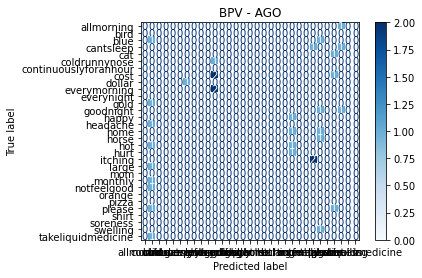

PCA inputs
    EMG0L EMG0L     EMG0L     EMG0L     EMG0L  ...  OYR  OYR  OYR  OYR  OYR
75      0     0 -0.355984  0.733631  0.328473  ...  130  128  126  125  123
57      0     0   7.47567  -12.9144   1.13808  ...  120  120  119  119  119
81      0     0  -1.77992   3.66815   7.33811  ...  112  108  105  101   97
64      0     0  0.355984  -2.15757   1.18211  ...  118  122  125  129  132
4       0     0  -8.89961   28.6643  -22.3191  ...   92   92   92   91   91
..    ...   ...       ...       ...       ...  ...  ...  ...  ...  ...  ...
0       0     0  -2.13591   12.9454  -18.1282  ...  131  128  123  116  111
5       0     0  -1.06795   1.48892   1.02874  ...  143  140  137  134  132
102     0     0 -0.355984   3.22552  -6.58686  ...   78   78   78   78   78
98      0     0 -0.355984  0.377646  0.350135  ...   23   23   23   23   23
61      0     0         0         0         0  ...   68   68   68   68   67

[75 rows x 1700 columns]
<class 'pandas.core.frame.DataFrame'>
    EMG0L EMG

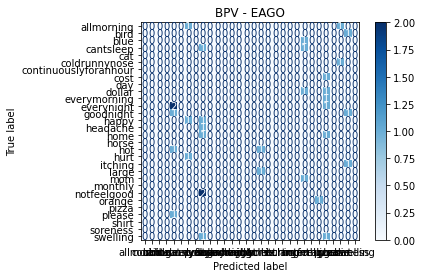

PCA inputs
        EMG0L     EMG0L     EMG0L  ...       EMG7R       EMG7R       EMG7R
55   0.175992 -0.186702   -0.1751  ...   0.0155482   0.0290474  0.00128895
13   0.181947 -0.193019 -0.186868  ...   0.0166765  -0.0017818   0.0130487
31   0.135613 -0.143865 -0.137623  ...   0.0131607    0.019386  -0.0279605
74   0.189728 -0.201273 -0.182698  ...  -0.0106151  0.00268209  -0.0132517
104  0.174634  -0.18526 -0.171764  ...  0.00784153   0.0457234   0.0148392
..        ...       ...       ...  ...         ...         ...         ...
68   0.148327 -0.157353 -0.150834  ...  -0.0233067  0.00853586 -0.00535731
12    0.21965 -0.233016 -0.218565  ...  -0.0273498  0.00362378   0.0241131
15   0.162221 -0.172092 -0.164061  ...  -0.0687216   0.0101643   0.0224561
107  0.140671 -0.149231  -0.14123  ...    0.045594   0.0556446  -0.0159757
52   0.115319 -0.122336 -0.115931  ...  -0.0619682  -0.0140584  -0.0161326

[75 rows x 800 columns]
<class 'pandas.core.frame.DataFrame'>
        EMG0L     EMG0L   

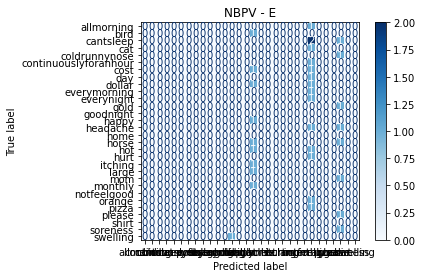

PCA inputs
           AXL        AXL       AXL  ...       AZR       AZR       AZR
99    0.125962   0.149193  0.195957  ...  0.551064  0.553025  0.558607
33   0.0660168  0.0345404  0.216156  ...  0.841224  0.806127  0.820612
29    0.230538   0.247909  0.333476  ...  0.770963  0.769032  0.768389
103   0.427949     0.4304  0.488694  ...  0.834377  0.829201  0.828112
45    0.658657    0.72429  0.814471  ...   0.84031  0.846512  0.848579
..         ...        ...       ...  ...       ...       ...       ...
83    0.198909   0.192633  0.202183  ...  0.793179   0.89768  0.972714
40    0.366549    0.35749  0.339373  ...  0.699514   0.70084  0.696421
12    0.268031   0.270982  0.276147  ...  0.807231   0.81092  0.812764
64    0.601984   0.594382  0.646114  ...  0.881122   0.87352  0.869298
35    0.143233  0.0957578  0.124849  ...  0.683232  0.685657  0.686666

[75 rows x 300 columns]
<class 'pandas.core.frame.DataFrame'>
            AXL        AXL        AXL  ...       AZR       AZR       AZR
2

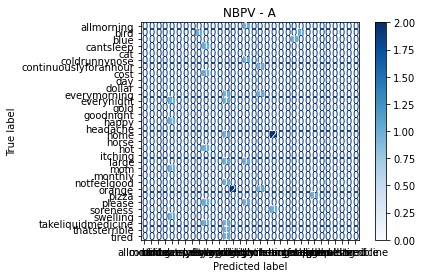

PCA inputs
         GXL       GXL       GXL  ...       GZR        GZR       GZR
0   0.447436  0.442208  0.300924  ...  0.121147  0.0281446         0
56  0.440221   0.44226  0.440941  ...  0.421394   0.423193  0.448256
60  0.381455  0.390995  0.444925  ...  0.356143   0.356398  0.369117
92  0.681769  0.830559  0.650234  ...  0.508773   0.512992   0.51166
68  0.475259  0.479602   0.52598  ...  0.487203   0.481774  0.495734
..       ...       ...       ...  ...       ...        ...       ...
29   0.42166  0.622397  0.604774  ...  0.642583   0.643544  0.642903
75  0.451696  0.453201  0.458127  ...  0.343184   0.388614  0.351395
8   0.474294   0.46966  0.467343  ...  0.328883   0.422882    0.4562
70  0.258208  0.314435  0.288877  ...  0.490705   0.447335  0.425804
95  0.496959  0.495193  0.510202  ...  0.607416   0.456935  0.377183

[75 rows x 300 columns]
<class 'pandas.core.frame.DataFrame'>
          GXL       GXL       GXL  ...        GZR        GZR        GZR
96    0.62643  0.601864  0

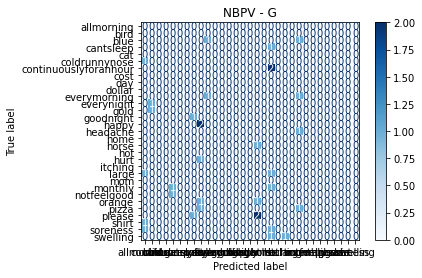

PCA inputs
           ORL        ORL        ORL  ...       OYR       OYR       OYR
69    0.457143   0.457143   0.457143  ...  0.828571  0.785714  0.757143
81    0.416667   0.416667   0.383333  ...  0.566667       0.5  0.433333
104  0.0392157  0.0392157  0.0392157  ...         1  0.980392  0.941176
82    0.439394   0.439394   0.439394  ...  0.818182  0.742424  0.651515
62    0.430769   0.430769   0.430769  ...  0.169231  0.169231  0.169231
..         ...        ...        ...  ...       ...       ...       ...
86    0.351955   0.351955   0.368715  ...  0.949721  0.921788  0.905028
36     0.46875    0.46875    0.46875  ...         0         0         0
73     0.42623    0.42623    0.42623  ...   0.52459  0.491803  0.491803
48    0.348148   0.348148   0.348148  ...  0.577778  0.585185  0.585185
33       0.375      0.375      0.375  ...  0.578125   0.59375   0.59375

[75 rows x 300 columns]
<class 'pandas.core.frame.DataFrame'>
           ORL        ORL        ORL  ...        OYR        OY

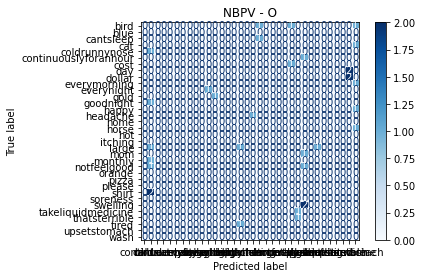

PCA inputs
        EMG0L     EMG0L     EMG0L  ...       AZR       AZR       AZR
96   0.173686 -0.184255 -0.178009  ...  0.734665  0.738945  0.736331
22   0.189423 -0.200949 -0.189576  ...  0.719335  0.718651  0.723667
106  0.209843 -0.222613 -0.217637  ...  0.938254  0.934396   0.91076
51   0.171233 -0.181653 -0.169921  ...  0.849675  0.850111  0.845971
56   0.222175 -0.235694 -0.221048  ...  0.697523  0.775373  0.824001
..        ...       ...       ...  ...       ...       ...       ...
50   0.169435 -0.179745 -0.168362  ...  0.669808   0.73382  0.718528
1    0.203108 -0.215467 -0.204138  ...  0.892058  0.923016  0.935032
12    0.21965 -0.233016 -0.218565  ...  0.807231   0.81092  0.812764
32   0.172598 -0.183101 -0.164369  ...  0.968774  0.947672  0.932639
105  0.169675     -0.18 -0.276676  ...  0.872537  0.874485  0.859888

[75 rows x 1100 columns]
<class 'pandas.core.frame.DataFrame'>
        EMG0L     EMG0L      EMG0L  ...       AZR       AZR       AZR
10   0.123919 -0.131459  -0

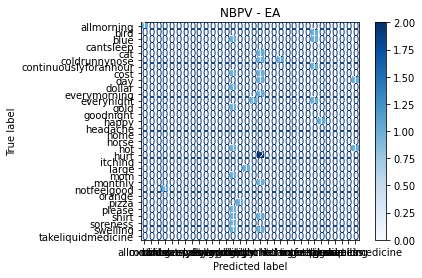

PCA inputs
       EMG0L     EMG0L     EMG0L  ...       GZR       GZR       GZR
75  0.214934 -0.228013 -0.213081  ...  0.343184  0.388614  0.351395
5   0.232669 -0.246828 -0.235826  ...  0.485268   0.41787  0.428841
45  0.163334 -0.173273 -0.135522  ...  0.530099  0.529077    0.5263
60   0.16113 -0.170935 -0.169724  ...  0.356143  0.356398  0.369117
16  0.107319 -0.113849  -0.10032  ...  0.433311  0.439022  0.439294
..       ...       ...       ...  ...       ...       ...       ...
17  0.147479 -0.156453 -0.155227  ...  0.467387  0.466307  0.464416
41  0.159694 -0.169411 -0.153743  ...  0.550108  0.543149  0.543613
97  0.213591 -0.226588 -0.208103  ...  0.539072  0.539468  0.542443
34  0.154434 -0.163832 -0.151897  ...  0.529939  0.533603  0.531482
74  0.189728 -0.201273 -0.182698  ...  0.449948  0.447225  0.446806

[75 rows x 1100 columns]
<class 'pandas.core.frame.DataFrame'>
        EMG0L     EMG0L      EMG0L  ...       GZR        GZR        GZR
58   0.148599 -0.157641  0.0106066  .

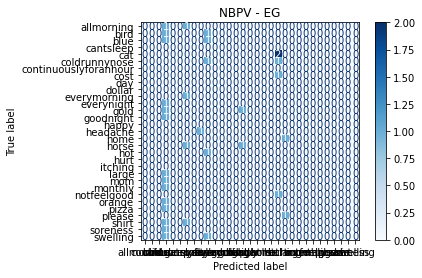

PCA inputs
        EMG0L     EMG0L      EMG0L  ...       OYR       OYR       OYR
100  0.197769 -0.209803  -0.190124  ...      0.79      0.79      0.79
31   0.135613 -0.143865  -0.137623  ...  0.423529  0.423529  0.423529
29   0.180499 -0.191483  -0.210123  ...  0.954128  0.954128  0.954128
57   0.140434  -0.14898 -0.0695424  ...  0.717391  0.717391  0.717391
32   0.172598 -0.183101  -0.164369  ...   0.46988  0.457831  0.457831
..        ...       ...        ...  ...       ...       ...       ...
69   0.197769 -0.209803  -0.179306  ...  0.828571  0.785714  0.757143
84    0.17869 -0.189564  -0.167378  ...  0.563107  0.563107  0.563107
16   0.107319 -0.113849   -0.10032  ...  0.569767   0.55814   0.55814
68   0.148327 -0.157353  -0.150834  ...  0.983146  0.983146  0.983146
17   0.147479 -0.156453  -0.155227  ...         0         0         0

[75 rows x 1100 columns]
<class 'pandas.core.frame.DataFrame'>
        EMG0L     EMG0L     EMG0L  ...        OYR        OYR        OYR
72   0.204332

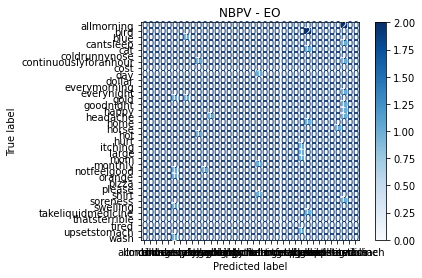

PCA inputs
          AXL        AXL       AXL  ...       GZR        GZR       GZR
51   0.531374   0.532246  0.532681  ...  0.603929   0.602095  0.603143
30   0.428332   0.494746  0.451031  ...  0.411172    0.41896  0.420303
104  0.199651   0.153153  0.173496  ...  0.176652  0.0163391         0
25   0.751488   0.646999  0.460468  ...  0.121531   0.376268  0.502803
63   0.377964   0.385389  0.350898  ...  0.858617   0.777189  0.765756
..        ...        ...       ...  ...       ...        ...       ...
85   0.308031    0.30886  0.306927  ...  0.816002   0.806524  0.783663
98   0.167066   0.166666  0.163469  ...  0.556688   0.556912  0.556912
101  0.116977  0.0791927  0.117495  ...  0.284747   0.329612  0.345963
48   0.101251   0.099835  0.103139  ...  0.505668   0.511607  0.505453
14   0.142777     0.1475  0.148611  ...   0.40098   0.363148  0.385204

[75 rows x 600 columns]
<class 'pandas.core.frame.DataFrame'>
            AXL        AXL        AXL  ...       GZR       GZR       GZR
2

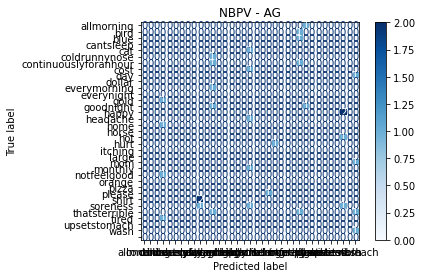

PCA inputs
          AXL        AXL       AXL  ...       OYR       OYR       OYR
77   0.289869   0.287688  0.293989  ...         0         0         0
35   0.143233  0.0957578  0.124849  ...  0.305085  0.305085  0.305085
81   0.289655   0.296552  0.357012  ...  0.566667       0.5  0.433333
72   0.379628   0.386852  0.461803  ...  0.534247  0.534247  0.534247
48   0.101251   0.099835  0.103139  ...  0.577778  0.585185  0.585185
..        ...        ...       ...  ...       ...       ...       ...
9    0.249737    0.38626  0.460568  ...  0.767677  0.757576  0.757576
13  0.0699109  0.0678545    0.0626  ...      0.68      0.68      0.68
42   0.197597   0.192702  0.145528  ...      0.75      0.75      0.75
17   0.125733   0.125245  0.131836  ...         0         0         0
85   0.308031    0.30886  0.306927  ...  0.654762  0.654762  0.642857

[75 rows x 600 columns]
<class 'pandas.core.frame.DataFrame'>
            AXL        AXL        AXL  ...        OYR        OYR        OYR
1      0.3

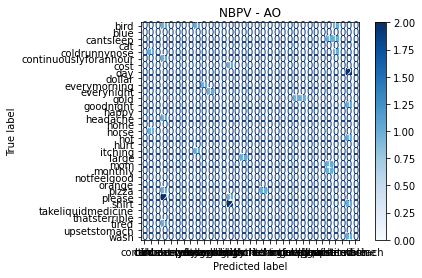

PCA inputs
          GXL       GXL       GXL  ...        OYR        OYR       OYR
2    0.275358  0.251881  0.581842  ...   0.135135   0.135135  0.135135
27   0.506525  0.468134  0.485281  ...          0          0         0
83   0.536367  0.536218  0.543209  ...   0.508197   0.409836  0.377049
16   0.443916  0.442965  0.445684  ...   0.569767    0.55814   0.55814
78   0.432221  0.469754  0.454781  ...   0.711538   0.711538  0.721154
..        ...       ...       ...  ...        ...        ...       ...
103  0.276077    0.2995  0.286287  ...   0.428571   0.428571  0.428571
7    0.456863  0.455668  0.460449  ...  0.0391061  0.0223464         0
100  0.505068  0.614589  0.800635  ...       0.79       0.79      0.79
22   0.314212  0.287442  0.201581  ...       0.02       0.02      0.02
99     0.7186  0.630223  0.657528  ...   0.592233   0.592233  0.592233

[75 rows x 600 columns]
<class 'pandas.core.frame.DataFrame'>
          GXL       GXL       GXL  ...        OYR        OYR        OYR
0 

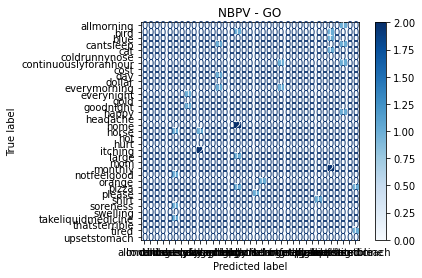

PCA inputs
       EMG0L     EMG0L     EMG0L  ...        GZR        GZR       GZR
0   0.173486 -0.184043 -0.184154  ...   0.121147  0.0281446         0
71  0.171301 -0.181725 -0.203281  ...   0.240089   0.267158  0.276279
1   0.203108 -0.215467 -0.204138  ...  0.0351987   0.107871  0.208028
79  0.209939 -0.222714 -0.211054  ...   0.466212   0.559076  0.619567
2   0.212442  -0.22537 -0.212779  ...   0.544228   0.536965  0.548508
..       ...       ...       ...  ...        ...        ...       ...
16  0.107319 -0.113849  -0.10032  ...   0.433311   0.439022  0.439294
59    0.1612  -0.17101  -0.18094  ...   0.177506   0.206543  0.217974
55  0.175992 -0.186702   -0.1751  ...   0.305854   0.296748  0.282764
30  0.179687 -0.190621 -0.176735  ...   0.411172    0.41896  0.420303
5   0.232669 -0.246828 -0.235826  ...   0.485268    0.41787  0.428841

[75 rows x 1400 columns]
<class 'pandas.core.frame.DataFrame'>
        EMG0L     EMG0L     EMG0L  ...       GZR       GZR       GZR
45   0.163334 -0

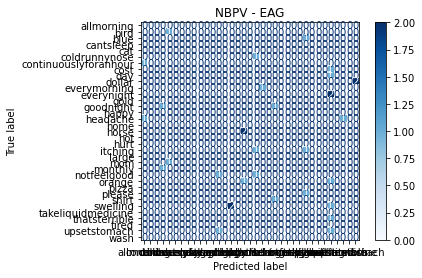

PCA inputs
        EMG0L     EMG0L     EMG0L  ...        OYR        OYR        OYR
61   0.143542 -0.152277 -0.141183  ...   0.145161   0.145161   0.129032
65   0.174569 -0.185192 -0.168278  ...   0.955307   0.949721   0.944134
88   0.175821  -0.18652 -0.177274  ...   0.446154   0.446154   0.446154
42   0.183036 -0.194174 -0.184352  ...       0.75       0.75       0.75
92   0.201335 -0.213587 -0.212616  ...  0.0612245  0.0612245  0.0612245
..        ...       ...       ...  ...        ...        ...        ...
103  0.162287 -0.172162 -0.164855  ...   0.428571   0.428571   0.428571
97   0.213591 -0.226588 -0.208103  ...    0.82243   0.813084   0.813084
60    0.16113 -0.170935 -0.169724  ...          0          0          0
6    0.159958 -0.169691 -0.160466  ...   0.346667   0.386667        0.4
39   0.158215 -0.167843 -0.160269  ...   0.657407   0.657407   0.648148

[75 rows x 1400 columns]
<class 'pandas.core.frame.DataFrame'>
        EMG0L     EMG0L      EMG0L  ...        OYR        OYR

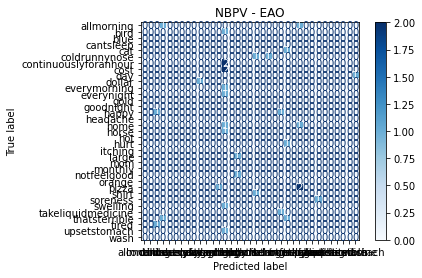

PCA inputs
        EMG0L     EMG0L     EMG0L  ...        OYR        OYR        OYR
87    0.18736 -0.198761   -0.1822  ...   0.307692   0.326923   0.307692
62   0.229772 -0.243754 -0.235705  ...   0.169231   0.169231   0.169231
11   0.166256 -0.176373  -0.16548  ...   0.747253   0.725275   0.714286
77   0.185228 -0.196499 -0.183631  ...          0          0          0
101  0.156532 -0.166057  -0.15396  ...   0.438202   0.438202   0.426966
..        ...       ...       ...  ...        ...        ...        ...
85   0.183925 -0.195117 -0.180903  ...   0.654762   0.654762   0.642857
74   0.189728 -0.201273 -0.182698  ...  0.0300752  0.0300752  0.0225564
45   0.163334 -0.173273 -0.135522  ...      0.625      0.625      0.625
59     0.1612  -0.17101  -0.18094  ...   0.904494   0.893258    0.88764
46   0.210852 -0.223683 -0.234771  ...   0.648148   0.648148   0.648148

[75 rows x 1400 columns]
<class 'pandas.core.frame.DataFrame'>
        EMG0L     EMG0L      EMG0L  ...        OYR        OYR

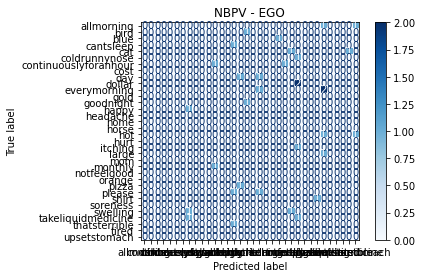

PCA inputs
           AXL        AXL        AXL  ...       OYR       OYR       OYR
83    0.198909   0.192633   0.202183  ...  0.508197  0.409836  0.377049
90    0.294488   0.282658    0.29625  ...  0.326087  0.326087  0.326087
93    0.340054   0.342114    0.34374  ...   0.62766   0.62766   0.62766
10    0.347607   0.432587   0.485728  ...  0.588235  0.564706  0.529412
31    0.349497   0.378385   0.379417  ...  0.423529  0.423529  0.423529
..         ...        ...        ...  ...       ...       ...       ...
101   0.116977  0.0791927   0.117495  ...  0.438202  0.438202  0.426966
68   0.0751992  0.0660572  0.0392212  ...  0.983146  0.983146  0.983146
37    0.359159   0.360366   0.360125  ...  0.833333  0.833333  0.826087
81    0.289655   0.296552   0.357012  ...  0.566667       0.5  0.433333
77    0.289869   0.287688   0.293989  ...         0         0         0

[75 rows x 900 columns]
<class 'pandas.core.frame.DataFrame'>
           AXL        AXL        AXL  ...        OYR        OY

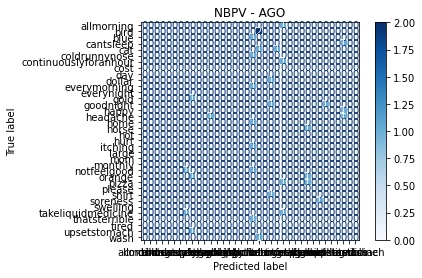

PCA inputs
       EMG0L     EMG0L     EMG0L  ...        OYR        OYR       OYR
12   0.21965 -0.233016 -0.218565  ...       0.57       0.57      0.57
89  0.191016 -0.202639 -0.192218  ...   0.478873   0.478873  0.492958
37  0.166594 -0.176731  -0.16561  ...   0.833333   0.833333  0.826087
29  0.180499 -0.191483 -0.210123  ...   0.954128   0.954128  0.954128
14   0.16536 -0.175423 -0.155753  ...   0.515385   0.507692  0.507692
..       ...       ...       ...  ...        ...        ...       ...
26  0.218337 -0.231623 -0.219496  ...    0.96648   0.944134  0.927374
91  0.114184 -0.121132 -0.116785  ...          0          0         0
8   0.151024 -0.160214 -0.148542  ...  0.0364964  0.0145985         0
77  0.185228 -0.196499 -0.183631  ...          0          0         0
75  0.214934 -0.228013 -0.213081  ...   0.669725    0.66055  0.642202

[75 rows x 1700 columns]
<class 'pandas.core.frame.DataFrame'>
        EMG0L     EMG0L     EMG0L  ...        OYR        OYR        OYR
62   0.229772

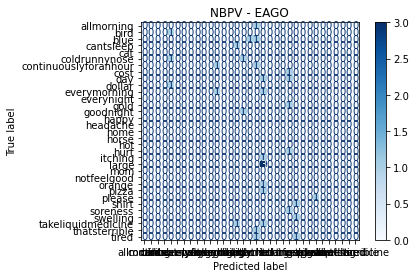

PCA inputs
          EMG0L       EMG0L       EMG0L  ...      EMG7R     EMG7R      EMG7R
54    0.0113353  -0.0120251    0.688748  ...  -0.554339 -0.235535  -0.870792
101  0.00247383 -0.00262437 -0.00243318  ...  -0.223435  -1.61419    -1.0581
92    0.0319597  -0.0339045   -0.283086  ...   0.191436  0.551117   -0.21852
105   0.0136111  -0.0144394    -1.02275  ...   0.640226  0.441976   0.028579
74    0.0205122  -0.0217604   0.0396055  ...  -0.162217  0.040987  -0.202508
..          ...         ...         ...  ...        ...       ...        ...
60    0.0430082  -0.0456253   -0.220882  ...  -0.214244 -0.414934 -0.0628184
36    0.0185773  -0.0197078  0.00998243  ... -0.0487528  0.246909  0.0361791
89   0.00854548 -0.00906548   -0.057944  ...    0.16396  -0.21293   0.591667
46    0.0429261  -0.0455382    -0.39625  ...   0.127518  0.277227 -0.0464942
5     0.0473415  -0.0502223   -0.153449  ...  -0.179463  0.785548    1.07466

[75 rows x 800 columns]
<class 'pandas.core.frame.DataFrame'>
  

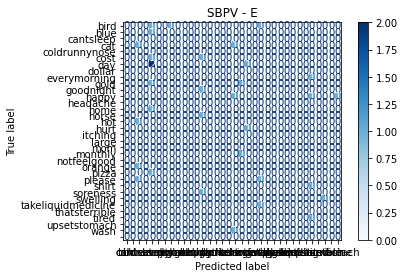

PCA inputs
         AXL        AXL        AXL  ...       AZR       AZR       AZR
44  -1.37356   -1.40543   -1.48208  ...   1.46942   1.49525   1.51161
97  -1.11864   -1.10653   -1.02779  ...   1.27285   1.28497    1.2032
8   -1.40906   -1.38624   -1.38053  ...   0.89472  0.496082  0.337932
41  -1.63035   -1.63558   -1.68441  ...    1.3763   1.37368   1.34316
76 -0.744128   -0.73298  -0.736696  ...   1.34534   1.41037   1.36578
..       ...        ...        ...  ...       ...       ...       ...
2  -0.257177  -0.604246  -0.245412  ...   1.18404   1.30993   1.08521
24 -0.236441  -0.294914  -0.478187  ...   1.12066   1.12589   1.17913
57  -0.15198 -0.0126978 -0.0505166  ...   1.02499   1.03237   1.03145
75  -1.32317   -1.32485   -1.32149  ...   1.68811    1.6117   1.70154
61  -1.31663   -1.33969   -1.40618  ...  0.945124   1.05329   1.02758

[75 rows x 300 columns]
<class 'pandas.core.frame.DataFrame'>
           AXL        AXL        AXL  ...        AZR         AZR        AZR
79   -0.31

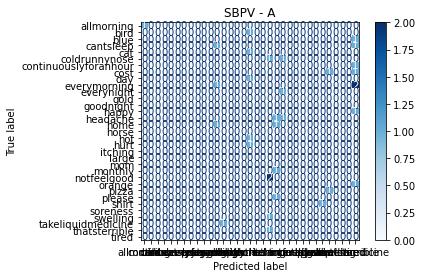

PCA inputs
           GXL         GXL         GXL  ...          GZR        GZR        GZR
17  -0.0262859  -0.0475522   0.0401712  ...  0.000296913 -0.0103362 -0.0289442
0    -0.103627   -0.144014    -1.23534  ...     -2.62399   -3.34237   -3.55977
13   0.0279427    0.071664   0.0221131  ...    0.0386301  0.0366869  0.0366869
24   0.0768855    0.106224  -0.0253557  ...  -0.00312932 -0.0858113 -0.0991471
16   0.0234397   0.0148836   0.0393296  ...      -0.0719 -0.0205632 -0.0181186
..         ...         ...         ...  ...          ...        ...        ...
86    0.314024    0.358241     0.90839  ...     -1.46188   -1.60584   -1.68914
53    0.229187    0.217424   0.0680391  ...     -1.79162   -2.18803   -1.90102
66  -0.0452973 -0.00770106 -0.00770106  ...    0.0449337  0.0524529  0.0242557
5    0.0318979   0.0563758    0.171116  ...     -1.59588   -2.25373   -2.14664
103  -0.844709   -0.658935   -0.763731  ...   -0.0762094 -0.0206361 -0.0253995

[75 rows x 300 columns]
<class 'pandas.c

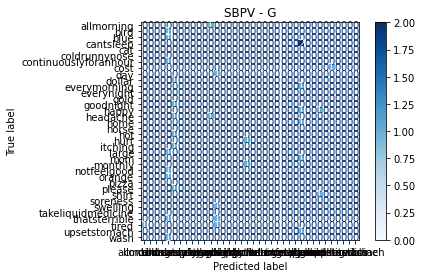

PCA inputs
           ORL        ORL       ORL  ...       OYR       OYR        OYR
103  -0.382353  -0.382353 -0.382353  ... -0.382353 -0.382353  -0.382353
30    -0.34649  -0.296826 -0.247162  ... -0.147833 -0.147833  -0.147833
57    0.275436   0.275436  0.153502  ...  0.925753  0.925753   0.925753
29    -1.11074   -1.11074  -1.11074  ...   1.79437   1.79437    1.79437
38   -0.196416  -0.196416 -0.164252  ...  -1.64381  -1.64381   -1.64381
..         ...        ...       ...  ...       ...       ...        ...
44   -0.141583  -0.224703 -0.307824  ...  -1.76244    -1.804   -1.84556
81   0.0118464  0.0118464 -0.115079  ...  0.583011   0.32916  0.0753091
101  -0.117678  -0.168328 -0.269629  ... -0.776134 -0.776134  -0.826784
60   -0.808918  -0.808918 -0.743524  ...  -1.52825  -1.52825   -1.52825
67    -1.00743   -1.00743  -1.03497  ...   1.30597   1.27843    1.27843

[75 rows x 300 columns]
<class 'pandas.core.frame.DataFrame'>
          ORL        ORL        ORL  ...         OYR        OY

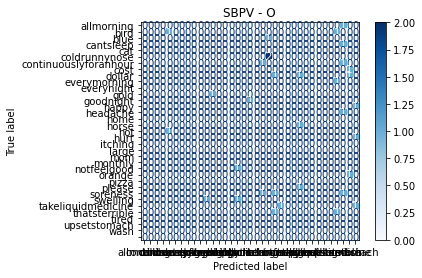

PCA inputs
          EMG0L       EMG0L      EMG0L  ...       AZR       AZR       AZR
18    0.0156711  -0.0166248   0.012696  ...   1.34284   1.29859   1.35188
48    0.0734478  -0.0779172  -0.128042  ...   1.05391   1.09497    1.1109
107   0.0214749  -0.0227817 -0.0503894  ...   1.19245   1.26182   1.25919
13    0.0879192  -0.0932691  -0.199554  ...   1.20902   1.18624   1.18286
103  0.00836664 -0.00887576 -0.0707835  ...   1.30469   1.28556   1.28153
..          ...         ...        ...  ...       ...       ...       ...
30    0.0430321  -0.0456507  -0.042325  ...   1.29882    1.3119   1.28387
10   0.00590135 -0.00626045  -0.159086  ...  0.894007  0.787782  0.879915
87    0.0344817    -0.03658 -0.0103781  ...   1.19808   1.10751   1.51754
28    0.0561488  -0.0595655 -0.0552262  ...   1.45079   1.38924   1.54652
96    0.0289015  -0.0306602  -0.138214  ...    1.3684   1.38529   1.37497

[75 rows x 1100 columns]
<class 'pandas.core.frame.DataFrame'>
          EMG0L       EMG0L       EMG

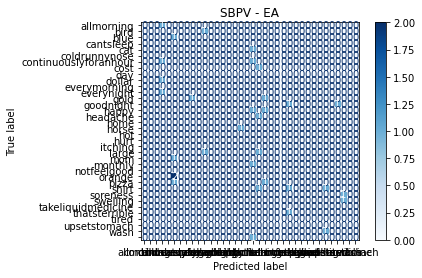

PCA inputs
          EMG0L       EMG0L       EMG0L  ...         GZR        GZR        GZR
47    0.0152612  -0.0161898  -0.0855822  ...  -0.0182213 -0.0201775 -0.0175692
66   0.00359369 -0.00381237  -0.0880921  ...   0.0449337  0.0524529  0.0242557
84  -0.00897959  0.00952601   0.0940139  ... -0.00431603  -0.191741  -0.151579
85    0.0225558  -0.0239283  -0.0221851  ...     0.69559   0.641711   0.511769
42    0.0178704  -0.0189578  -0.0913958  ...  -0.0660148   0.109709  0.0919496
..          ...         ...         ...  ...         ...        ...        ...
86   0.00889997 -0.00944155   0.0150589  ...    -1.46188   -1.60584   -1.68914
101  0.00247383 -0.00262437 -0.00243318  ...    -1.04011  -0.806391  -0.721215
82     0.046933  -0.0497889   0.0280406  ...    -1.94541   -2.35285   -3.10356
53    0.0445367  -0.0472468   -0.109908  ...    -1.79162   -2.18803   -1.90102
4     0.0200739  -0.0212954   -0.462388  ...  -0.0941719  -0.216255  -0.477862

[75 rows x 1100 columns]
<class 'pandas.

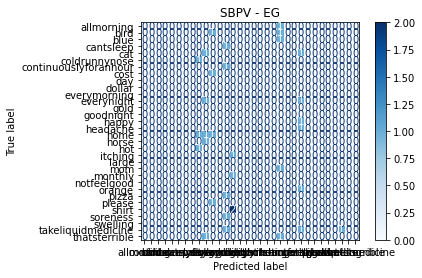

PCA inputs
          EMG0L       EMG0L      EMG0L  ...        OYR        OYR        OYR
31    0.0595685  -0.0631933  -0.123603  ...   -1.28766   -1.28766   -1.28766
74    0.0205122  -0.0217604  0.0396055  ...   -1.41836   -1.41836    -1.4436
20   0.00118656 -0.00125877   0.219195  ...  -0.810307  -0.855001  -0.899696
78    0.0482939  -0.0512327 -0.0475004  ...    1.14864    1.14864    1.18258
41    0.0436451  -0.0463009 -0.0021857  ...   -1.83249   -1.87386    -1.9566
..          ...         ...        ...  ...        ...        ...        ...
91     0.021743  -0.0230661 -0.0955621  ...   -2.04419   -2.04419   -2.04419
96    0.0289015  -0.0306602  -0.138214  ... -0.0454042 -0.0454042 -0.0454042
90    0.0429245  -0.0455365 -0.0869323  ...   -0.41661   -0.41661   -0.41661
107   0.0214749  -0.0227817 -0.0503894  ...   0.940625   0.855629   0.770633
98   0.00112298 -0.00119132 -0.0343781  ...   -1.70996   -1.70996   -1.70996

[75 rows x 1100 columns]
<class 'pandas.core.frame.DataFrame'>
 

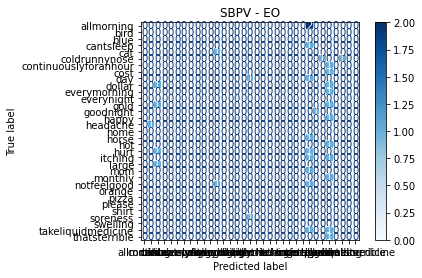

PCA inputs
          AXL       AXL       AXL  ...         GZR          GZR         GZR
82   -0.68612 -0.690342 -0.675983  ...    -1.94541     -2.35285    -3.10356
93   -1.51391  -1.49783  -1.48513  ...  -0.0880568    0.0278288   -0.376161
54   -1.04281  -1.05946  -1.05724  ...  0.00543697   -0.0539077  -0.0454299
68   -1.20819  -1.23475  -1.31273  ...  -0.0653875    -0.107698  0.00110007
24  -0.236441 -0.294914 -0.478187  ... -0.00312932   -0.0858113  -0.0991471
..        ...       ...       ...  ...         ...          ...         ...
104 -0.917807  -1.05292 -0.993811  ...    -1.27215     -2.50926    -2.63535
62   -1.38041  -1.38484  -1.38662  ...  -0.0484464 -0.000761905   0.0188729
95     -1.191  -1.20327  -1.09941  ...    0.911795    -0.317588   -0.969145
84  -0.642777  0.356745  0.797831  ... -0.00431603    -0.191741   -0.151579
3     -1.2187  -1.22123  -1.27613  ...   -0.136774   -0.0549075 -0.00828905

[75 rows x 600 columns]
<class 'pandas.core.frame.DataFrame'>
           AXL

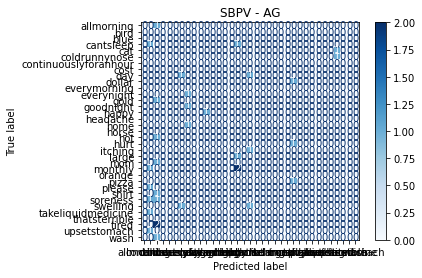

PCA inputs
          AXL       AXL       AXL  ...       OYR       OYR       OYR
90  -0.889831 -0.932742  -0.88344  ...  -0.41661  -0.41661  -0.41661
67   -0.41737  -0.41997 -0.413038  ...   1.30597   1.27843   1.27843
8    -1.40906  -1.38624  -1.38053  ...  -2.15961  -2.23619  -2.28724
107  -1.08614  -1.08175 -0.756864  ...  0.940625  0.855629  0.770633
76  -0.744128  -0.73298 -0.736696  ...  -1.12863  -1.12863  -1.12863
..        ...       ...       ...  ...       ...       ...       ...
51  -0.199693 -0.195932  -0.19405  ...  -1.95518  -1.95518  -1.95518
36   0.486925  0.481311  0.499088  ...  -1.92931  -1.92931  -1.92931
92  -0.432682 -0.537565 -0.786425  ...  -1.95225  -1.95225  -1.95225
17   -1.27113  -1.27283   -1.2499  ...  -1.50128  -1.50128  -1.50128
53    -1.0759   -1.0734  -1.06173  ...  0.616572  0.544552  0.496538

[75 rows x 600 columns]
<class 'pandas.core.frame.DataFrame'>
          AXL       AXL        AXL  ...         OYR        OYR        OYR
43  -0.688189 -0.684973 

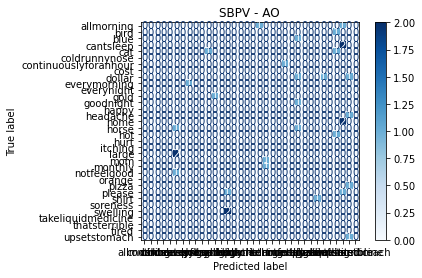

PCA inputs
           GXL         GXL        GXL  ...        OYR        OYR        OYR
9    -0.789353    -0.81161  -0.387966  ...    1.12092    1.07574    1.07574
88    -1.80407    -1.56639   0.035597  ...  -0.718118  -0.718118  -0.718118
8     0.081686   0.0460855  0.0282852  ...   -2.15961   -2.23619   -2.28724
34   -0.401903   -0.683644  -0.530095  ...   -1.27985   -1.27985   -1.27985
51   0.0511689   0.0687674   0.123163  ...   -1.95518   -1.95518   -1.95518
..         ...         ...        ...  ...        ...        ...        ...
65   -0.135245   -0.161239   0.405812  ...    2.03727    2.00964      1.982
43   0.0214681   0.0439087  0.0414153  ...  -0.377771  -0.377771  -0.377771
79 -0.00663529  0.00364313 -0.0546013  ...    2.01432    2.04117    2.06802
96    0.101333    -0.10117  0.0059005  ... -0.0454042 -0.0454042 -0.0454042
20   -0.289379   0.0166117    1.07407  ...  -0.810307  -0.855001  -0.899696

[75 rows x 600 columns]
<class 'pandas.core.frame.DataFrame'>
             G

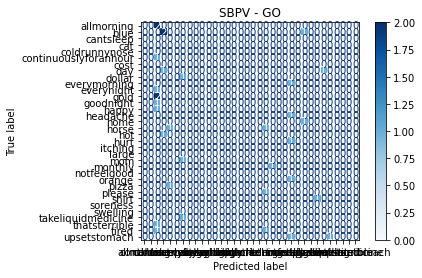

PCA inputs
          EMG0L       EMG0L       EMG0L  ...          GZR        GZR        GZR
76   0.00902367 -0.00957278  0.00881808  ... -0.000176079  0.0956869   0.145271
60    0.0430082  -0.0456253   -0.220882  ...    -0.146922  -0.144642  -0.030676
49    0.0189668  -0.0201209   -0.252607  ...   -0.0153073 -0.0270748 -0.0167782
38    0.0686706  -0.0728493  -0.0675422  ...   -0.0817301 -0.0472524 -0.0170844
104   0.0258085   -0.027379  -0.0253844  ...     -1.27215   -2.50926   -2.63535
..          ...         ...         ...  ...          ...        ...        ...
57    0.0383999  -0.0407365     1.07259  ...    -0.112745  -0.172718  -0.197823
0     0.0346613  -0.0367705   -0.264847  ...     -2.62399   -3.34237   -3.55977
37    0.0316767  -0.0336042  -0.0588516  ...    -0.165195  -0.213573  -0.213573
99  -0.00693925  0.00736151    -0.17552  ...    0.0566121  -0.007032 -0.0257903
103  0.00836664 -0.00887576  -0.0707835  ...   -0.0762094 -0.0206361 -0.0253995

[75 rows x 1400 columns]
<cl

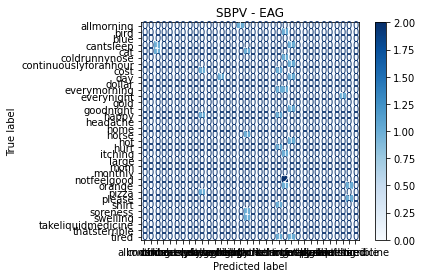

PCA inputs
          EMG0L       EMG0L      EMG0L  ...       OYR       OYR       OYR
42    0.0178704  -0.0189578 -0.0913958  ...  0.495261  0.495261  0.495261
60    0.0430082  -0.0456253  -0.220882  ...  -1.52825  -1.52825  -1.52825
14    0.0331723  -0.0351908  0.0446674  ... -0.170263 -0.208871 -0.208871
3     0.0321151  -0.0340693 -0.0617778  ...  0.524493  0.483971  0.483971
52    0.0293591  -0.0311457 -0.0718151  ... -0.806665  -0.78088  -0.78088
..          ...         ...        ...  ...       ...       ...       ...
103  0.00836664 -0.00887576 -0.0707835  ... -0.382353 -0.382353 -0.382353
17    0.0207138  -0.0219743  -0.203479  ...  -1.50128  -1.50128  -1.50128
1     0.0543823  -0.0576915  -0.133097  ...  0.529035   0.34192  0.192229
98   0.00112298 -0.00119132 -0.0343781  ...  -1.70996  -1.70996  -1.70996
26    0.0418564  -0.0444034 -0.0944041  ...   2.29411   2.18842   2.10916

[75 rows x 1400 columns]
<class 'pandas.core.frame.DataFrame'>
          EMG0L       EMG0L       EMG

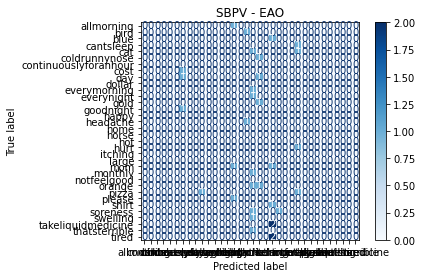

PCA inputs
          EMG0L       EMG0L       EMG0L  ...       OYR       OYR       OYR
69    0.0516775  -0.0548221    0.202493  ...    1.2488   1.09723  0.996177
52    0.0293591  -0.0311457  -0.0718151  ... -0.806665  -0.78088  -0.78088
54    0.0113353  -0.0120251    0.688748  ...  -2.36596  -2.36596  -2.36596
43    0.0527119  -0.0559194  -0.0518457  ... -0.377771 -0.377771 -0.377771
39    0.0219745  -0.0233117  -0.0995717  ...  0.955416  0.955416  0.917189
..          ...         ...         ...  ...       ...       ...       ...
15    0.0474267  -0.0503127   -0.110307  ... -0.793416 -0.793416 -0.855401
64    0.0221293  -0.0234759  0.00275433  ...   0.94634   1.06828   1.15973
76   0.00902367 -0.00957278  0.00881808  ...  -1.12863  -1.12863  -1.12863
107   0.0214749  -0.0227817  -0.0503894  ...  0.940625  0.855629  0.770633
0     0.0346613  -0.0367705   -0.264847  ...   1.30366   1.05442  0.876385

[75 rows x 1400 columns]
<class 'pandas.core.frame.DataFrame'>
          EMG0L       EMG

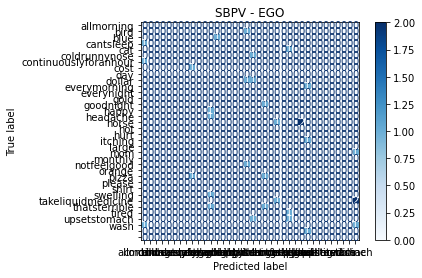

PCA inputs
         AXL       AXL        AXL  ...        OYR        OYR        OYR
9   -1.04873  -0.35017  0.0300502  ...    1.12092    1.07574    1.07574
81 -0.916842 -0.890219  -0.656834  ...   0.583011    0.32916  0.0753091
60  -1.08316   -1.0545   -1.09705  ...   -1.52825   -1.52825   -1.52825
13 -0.995956  -1.00355   -1.02296  ...  -0.141255  -0.141255  -0.141255
24 -0.236441 -0.294914  -0.478187  ...   -1.70394   -1.70394   -1.70394
..       ...       ...        ...  ...        ...        ...        ...
33  -1.66176  -1.77512   -1.12105  ...    0.10483   0.170623   0.170623
64  -0.11358 -0.149508  0.0950052  ...    0.94634    1.06828    1.15973
46  -1.52444  -1.13545   -1.04866  ...  0.0729676  0.0729676  0.0729676
1   -1.10529  -1.12642  -0.727572  ...   0.529035    0.34192   0.192229
95    -1.191  -1.20327   -1.09941  ...   -1.03336   -1.03336   -1.09091

[75 rows x 900 columns]
<class 'pandas.core.frame.DataFrame'>
           AXL        AXL        AXL  ...       OYR       OYR 

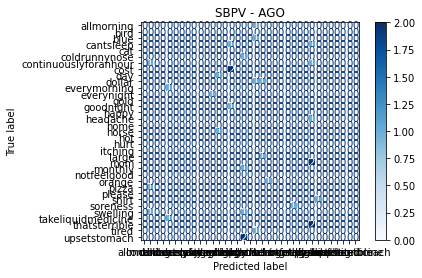

PCA inputs
          EMG0L       EMG0L       EMG0L  ...       OYR       OYR       OYR
70    0.0264389  -0.0280478   0.0745238  ...  0.974951  0.974951  0.974951
91     0.021743  -0.0230661  -0.0955621  ...  -2.04419  -2.04419  -2.04419
65   0.00740057  -0.0078509   0.0292671  ...   2.03727   2.00964     1.982
69    0.0516775  -0.0548221    0.202493  ...    1.2488   1.09723  0.996177
101  0.00247383 -0.00262437 -0.00243318  ... -0.776134 -0.776134 -0.826784
..          ...         ...         ...  ...       ...       ...       ...
93     0.031216  -0.0331155   0.0322007  ...  0.298559  0.298559  0.298559
99  -0.00693925  0.00736151    -0.17552  ...  0.114515  0.114515  0.114515
103  0.00836664 -0.00887576  -0.0707835  ... -0.382353 -0.382353 -0.382353
88     0.034252  -0.0363363  -0.0757162  ... -0.718118 -0.718118 -0.718118
84  -0.00897959  0.00952601   0.0940139  ... -0.272546 -0.272546 -0.272546

[75 rows x 1700 columns]
<class 'pandas.core.frame.DataFrame'>
          EMG0L       EMG

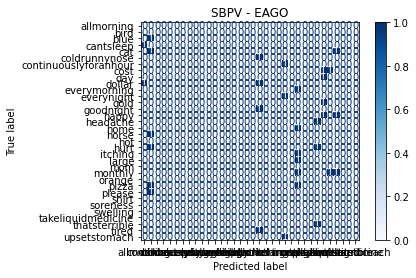

In [11]:
for st in steps:
  rownum+=1
  columnnum=-1
  for pr in regproducts:
    columnnum+=1
    combo=nsteps[rownum]+' - '+comb[columnnum]
    words=set(pr['Word']) # Obtain the target names for the SVM
    
    # First step: set input matrix as regular, normalized or standardized
    input_matrix=pr
    if st%3==0: # Normalization
      input_matrix=normproducts[columnnum]
    if st%5==0: # Standardization
      input_matrix=stanproducts[columnnum]
    
    # Second step: apply Butterworth
    two_matrix=input_matrix
    if st%7==0: # Butterworth
      two_matrix=butterworth(input_matrix)
    
    # Third step: split data for later steps
    x_train, x_test, y_train, y_test=datasplit(two_matrix)
    
    # Fourth step: apply PCA
    x_t_train=x_train
    x_t_test=x_test
    if st%11==0: # PCA
      x_train, x_test, y_train, y_test, x_t_train, x_t_test=pca(x_train, x_test, y_train, y_test)
    
    # Fifth step: apply SVM
    if st%13==0: # SVM
      #svmresults,accuracy,par=svm(x_train, x_test, y_train, y_test, x_t_train, x_t_test,combo)
      svmresults,accuracy=svm(x_train, x_test, y_train, y_test, x_t_train, x_t_test,combo)
    
    #print('The best parameters for',combo,'are:',par)
    fresults[rownum,columnnum]=accuracy*100
fresults=pd.DataFrame(fresults,index=nsteps,columns=comb)
exec("fresults.to_csv(path_or_buf='/content/results_'+str(numreps)+'.csv')")

endtime=time.time()

# **5. Results**

In [12]:
print(fresults)
print('The maximum accuracy for',numreps,'repetitions is',fresults.max().max())
print('The program executed in '+str(endtime-starttime)+' seconds')

             E         A         G  ...       EGO       AGO      EAGO
V     0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000
NV    0.000000  0.000000  2.750000  ...  2.750000  3.666667  0.000000
SV    0.000000  0.000000  0.000000  ...  2.750000  3.666667  0.000000
BV    0.000000  0.250000  0.000000  ...  0.000000  0.000000  0.000000
PV    3.666667  3.916667  0.000000  ...  0.000000  0.000000  3.916667
NBV   0.000000  3.666667  0.000000  ...  0.000000  0.000000  0.000000
NPV   0.000000  3.916667  0.000000  ...  9.166667  0.000000  7.583333
SBV   0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000
SPV   0.000000  2.750000  3.666667  ...  3.916667  0.000000  0.000000
BPV   0.000000  0.000000  0.000000  ...  2.750000  0.000000  0.000000
NBPV  3.666667  2.750000  3.666667  ...  3.000000  0.000000  0.000000
SBPV  0.000000  7.333333  0.000000  ...  3.666667  0.000000  0.000000

[12 rows x 15 columns]
The maximum accuracy for 3 repetitions is 20.416666666666668
The p